# Analysis of Ham10000 Response, Feature & Attention KD with high capacity teacher (ResNet101)

In [7]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()
import plotly.io as pio
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import math
import re
import os
import seaborn as sns
plt.rcParams['figure.dpi'] = 250
from scipy.spatial import distance

## Read Data

### Teacher: 
- Resnet101, Seed 42, r101-sam1-s42

### Students:
No Female:
- Resnet18: Seeds 43, 46
- Resnet34: Seeds 42, 43

No Old:
- Resnet18: Seeds 43, 46
- Resnet34: Seeds 42, 43

In [6]:
def read_data(path, teacher_id=None):
    test_data = []
    for folder in os.scandir(path):
        if teacher_id is not None:
            if folder.is_dir() and teacher_id in folder.name:
                # Perform operations on the folder
                file_path = path + folder.name
                if os.path.exists(file_path + '/test.csv'):
                    df_tmp = pd.read_csv(file_path + '/test.csv')
                    test_data.append(df_tmp)
        else:
            if folder.is_dir():
                # Perform operations on the folder
                file_path = path + folder.name
                if os.path.exists(file_path + '/test.csv'):
                    df_tmp = pd.read_csv(file_path + '/test.csv')
                    test_data.append(df_tmp)

    df = pd.concat(test_data)
    df['auc_gap_relative'] = df['auc_gap'] / df['auc']
    df['age_auc'] = (df['age_auc_group_0'] + df['age_auc_group_1']) / 2
    df['sex_auc'] = (df['sex_auc_group_0'] + df['sex_auc_group_1']) / 2
    df['age_auc_gap'] = abs(df['age_auc_group_0'] - df['age_auc_group_1'])
    df['sex_auc_gap'] = abs(df['sex_auc_group_0'] - df['sex_auc_group_1'])
    df['avg_auc_gap'] = (df['age_auc_gap'] + df['sex_auc_gap']) / 2
    df['age_auc_gap_relative'] = df['age_auc_gap'] / df['auc']
    df['sex_auc_gap_relative'] = df['sex_auc_gap'] / df['auc']
    df['avg_auc_gap_relative'] = df['avg_auc_gap'] / df['auc']
    return df


original_df = read_data('../../results/ham10000/resnet/original/')
print(original_df.shape)

kd_normal_capacity_no_female_df = read_data('../../results/ham10000_no_female/kd/', 'r34-sam1-s46')
kd_normal_capacity_no_old_df = read_data('../../results/ham10000_no_old/kd/', 'r34-sam1-s46')
print(kd_normal_capacity_no_female_df.shape, kd_normal_capacity_no_old_df.shape)


kd_no_female_df = read_data('../../results/ham10000_no_female/kd/', 'r101-sam1-s42')
kd_no_old_df = read_data('../../results/ham10000_no_old/kd/', 'r101-sam1-s42')
feature_no_female_df = read_data('../../results/ham10000_no_female/kd-feature_rgb/', 'r101-sam1-s42')
feature_no_old_df = read_data('../../results/ham10000_no_old/kd-feature_rgb/', 'r101-sam1-s42')
attention_no_female_df = read_data('../../results/ham10000_no_female/attention_kd/', 'r101-sam1-s42')
attention_no_old_df = read_data('../../results/ham10000_no_old/attention_kd/', 'r101-sam1-s42')

print(kd_no_female_df.shape, kd_no_old_df.shape, feature_no_female_df.shape, feature_no_old_df.shape, attention_no_female_df.shape, attention_no_old_df.shape)

# Baselines
no_female_df = read_data('../../results/ham10000_no_female/resnet/')
no_female_df = no_female_df[no_female_df['model_name'].isin(['resnet18', 'resnet34'])]
no_old_df = read_data('../../results/ham10000_no_old/resnet/')
no_old_df = no_old_df[no_old_df['model_name'].isin(['resnet18', 'resnet34'])]

print(no_female_df.shape, no_old_df.shape)


(40, 72)
(10, 71) (10, 71)
(10, 71) (10, 71) (10, 72) (10, 72) (10, 72) (10, 72)
(10, 71) (10, 71)


## Overall Performance

In [14]:
def kd_overall_model_performance(
        resnet_df: pd.DataFrame,
        kd_df: pd.DataFrame,
        feature_df: pd.DataFrame,
        attention_df: pd.DataFrame,
        teacher_df: pd.DataFrame,
        teacher_id: str,
        metric: str,
        title: str = '',
        bar_width=0.2, 
        line_length=0.05,
    ):

    kd_df = kd_df.sort_values(by=['model_name'])
    feature_df = feature_df.sort_values(by=['model_name'])
    attention_df = attention_df.sort_values(by=['model_name'])

    # Get teachers from resnet_df
    teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][metric]
                            
    # Set up graphical variables
    total_bars = 4
    bar_group_width = bar_width * total_bars
    legend_handles = []
    legend_labels = []

    # Set up the plot
    fig, ax = plt.subplots(figsize=(11, 7))

    # Create the plot
    for i, model in enumerate(kd_df['model_name'].unique()):
        model_scores = []

        # Get without KD
        scores = resnet_df[(resnet_df['model_name'] == model)][metric]
        mean_score = scores.mean()
        std_error = scores.std()
        model_scores.append(mean_score)
        x_pos_no_kd = i - bar_group_width/2 + (0 + 0.5) * bar_width
        handle_no_kd = ax.errorbar(x_pos_no_kd, mean_score, yerr=std_error, marker='D', capsize=5, markersize=12, markerfacecolor='blue', markeredgecolor='black', ecolor='gray', linewidth=0.9)
        if 'Baseline: No KD' not in legend_labels:
            legend_handles.append(handle_no_kd)
            legend_labels.append('Baseline: No KD')

        # Get with KD
        scores = kd_df[(kd_df['model_name'] == model)][metric]
        mean_score = scores.mean()
        std_error = scores.std()
        model_scores.append(mean_score)
        x_pos_kd = i - bar_group_width/2 + (1 + 0.5) * bar_width
        handle_kd = ax.errorbar(x_pos_kd, mean_score, yerr=std_error, marker='o', capsize=5, markersize=12, markerfacecolor='orange', markeredgecolor='black', ecolor='gray', linewidth=0.9)
        if 'With KD' not in legend_labels:
            legend_handles.append(handle_kd)
            legend_labels.append('With KD')


        # Get with Feature KD
        scores = feature_df[(feature_df['model_name'] == model)][metric]
        mean_score = scores.mean()
        std_error = scores.std()
        model_scores.append(mean_score)
        x_pos_feature_kd = i - bar_group_width/2 + (2 + 0.5) * bar_width
        handle_feature_kd = ax.errorbar(x_pos_feature_kd, mean_score, yerr=std_error, marker='s', capsize=5, markersize=12, markerfacecolor='green', markeredgecolor='black', ecolor='gray', linewidth=0.9)
        if 'With Feature KD' not in legend_labels:
            legend_handles.append(handle_feature_kd)
            legend_labels.append('With Feature KD')

        # Get with Attention KD
        scores = attention_df[(attention_df['model_name'] == model)][metric]
        mean_score = scores.mean()
        std_error = scores.std()
        model_scores.append(mean_score)
        x_pos_attention_kd = i - bar_group_width/2 + (3 + 0.5) * bar_width
        handle_attention_kd = ax.errorbar(x_pos_attention_kd, mean_score, yerr=std_error, marker='^', capsize=5, markersize=12, markerfacecolor='purple', markeredgecolor='black', ecolor='gray', linewidth=0.9)
        if 'With Attention KD' not in legend_labels:
            legend_handles.append(handle_attention_kd)
            legend_labels.append('With Attention KD')

        # Draw a dotted line between No KD and KD
        ax.plot([x_pos_no_kd, x_pos_kd, x_pos_feature_kd, x_pos_attention_kd], [model_scores[0], model_scores[1], model_scores[2], model_scores[3]], linestyle=':', color='grey')
        # ax.plot([x_pos_no_kd, x_pos_kd, x_pos_feature_kd], [model_scores[0], model_scores[1], model_scores[2]], linestyle=':', color='grey')


    # Show Teacher performance:
    teacher = ax.axhline(y=teacher_performance[0], linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='red')
    legend_handles.append(teacher)
    legend_labels.append('Teacher Performance')
    # Add text above the teacher performance line
    # ax.text(-0.45, teacher_performance[0], 'Teacher Performance', color='black', va='bottom')

    # Customize the plot
    ax.set_xticks(np.arange(len(kd_df['model_name'].unique())))
    ax.set_xticklabels(kd_df['model_name'].unique(), fontsize=15)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylabel('AUC', fontsize=15) 
    # Set the x-axis limits to show all the error bars
    ax.set_xlim(-bar_group_width/2, len(kd_df['model_name'].unique())-1+bar_group_width/2)
    ax.set_facecolor('#F0F0F0')
    # Legend
    # ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', handlelength=3.0, handletextpad=0.5, prop={'size': 12})
    ax.legend(handles=legend_handles, labels=legend_labels, loc='lower right', handlelength=3.0, handletextpad=0.5, prop={'size': 12})
    # Grid
    ax.yaxis.grid(True, linestyle='dotted', linewidth=0.8, color='white', alpha=1)
    # Title
    fig.suptitle(title, fontsize=18, y=0.98)

    # plt.show()

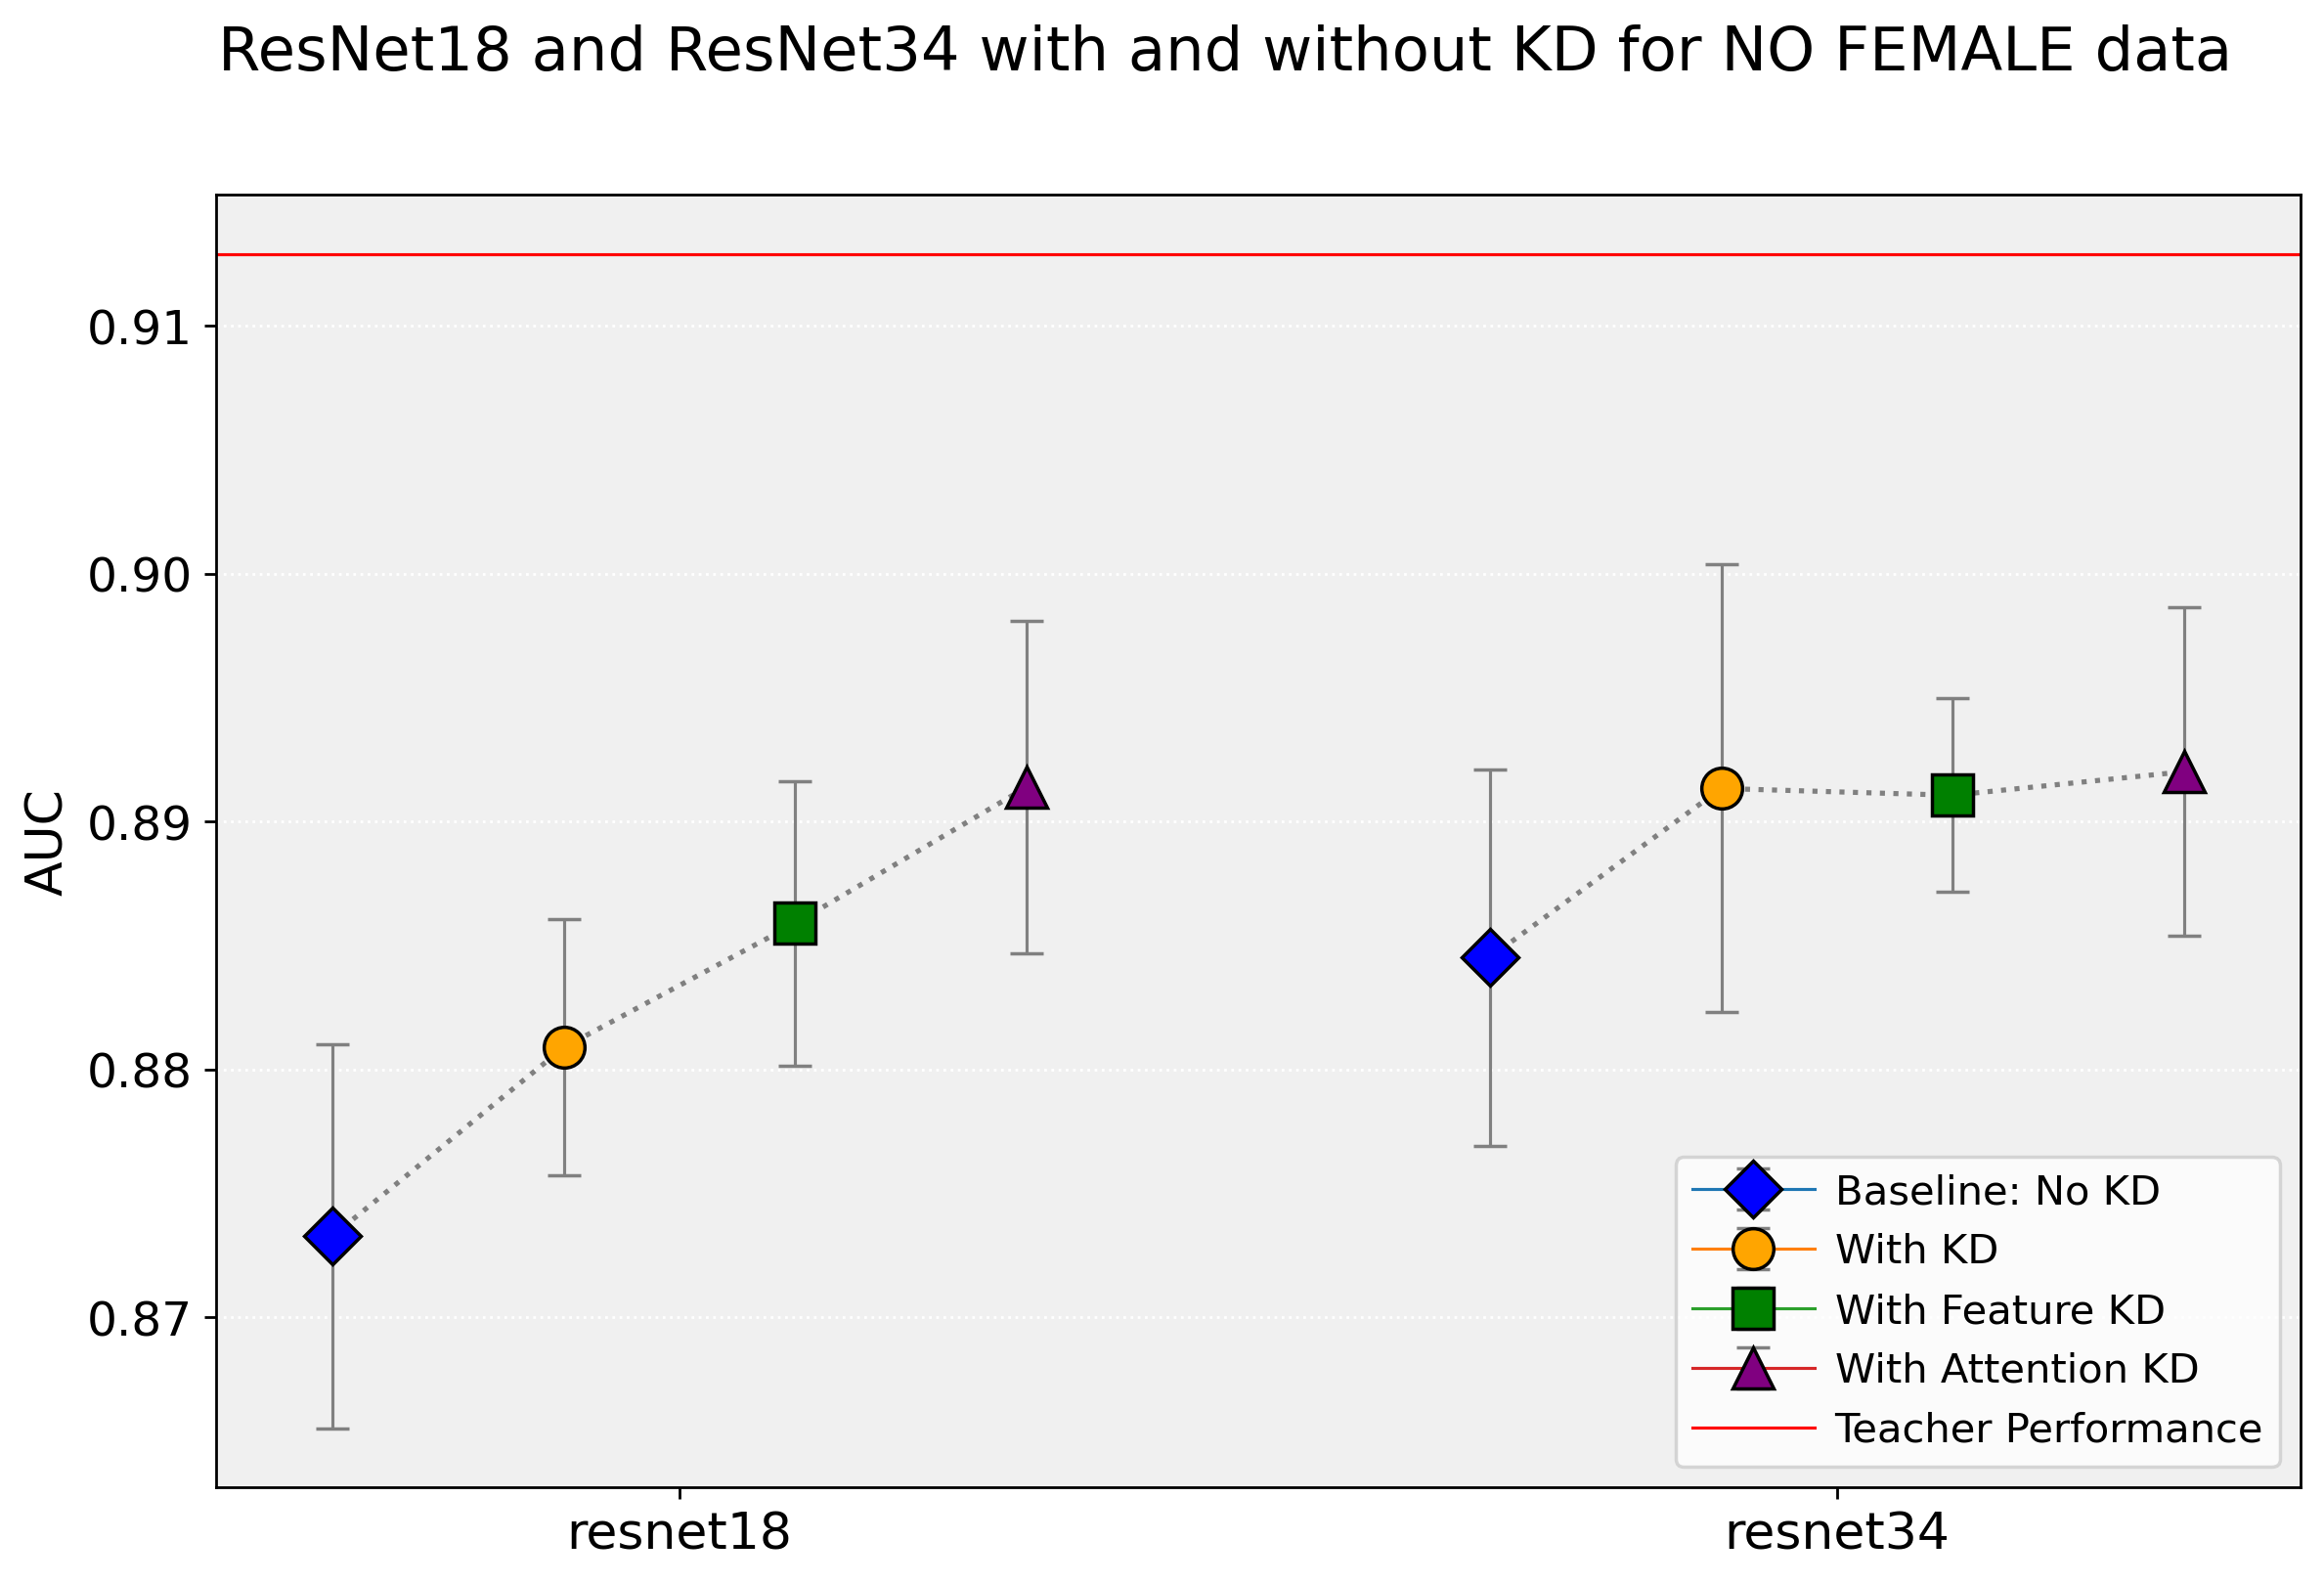

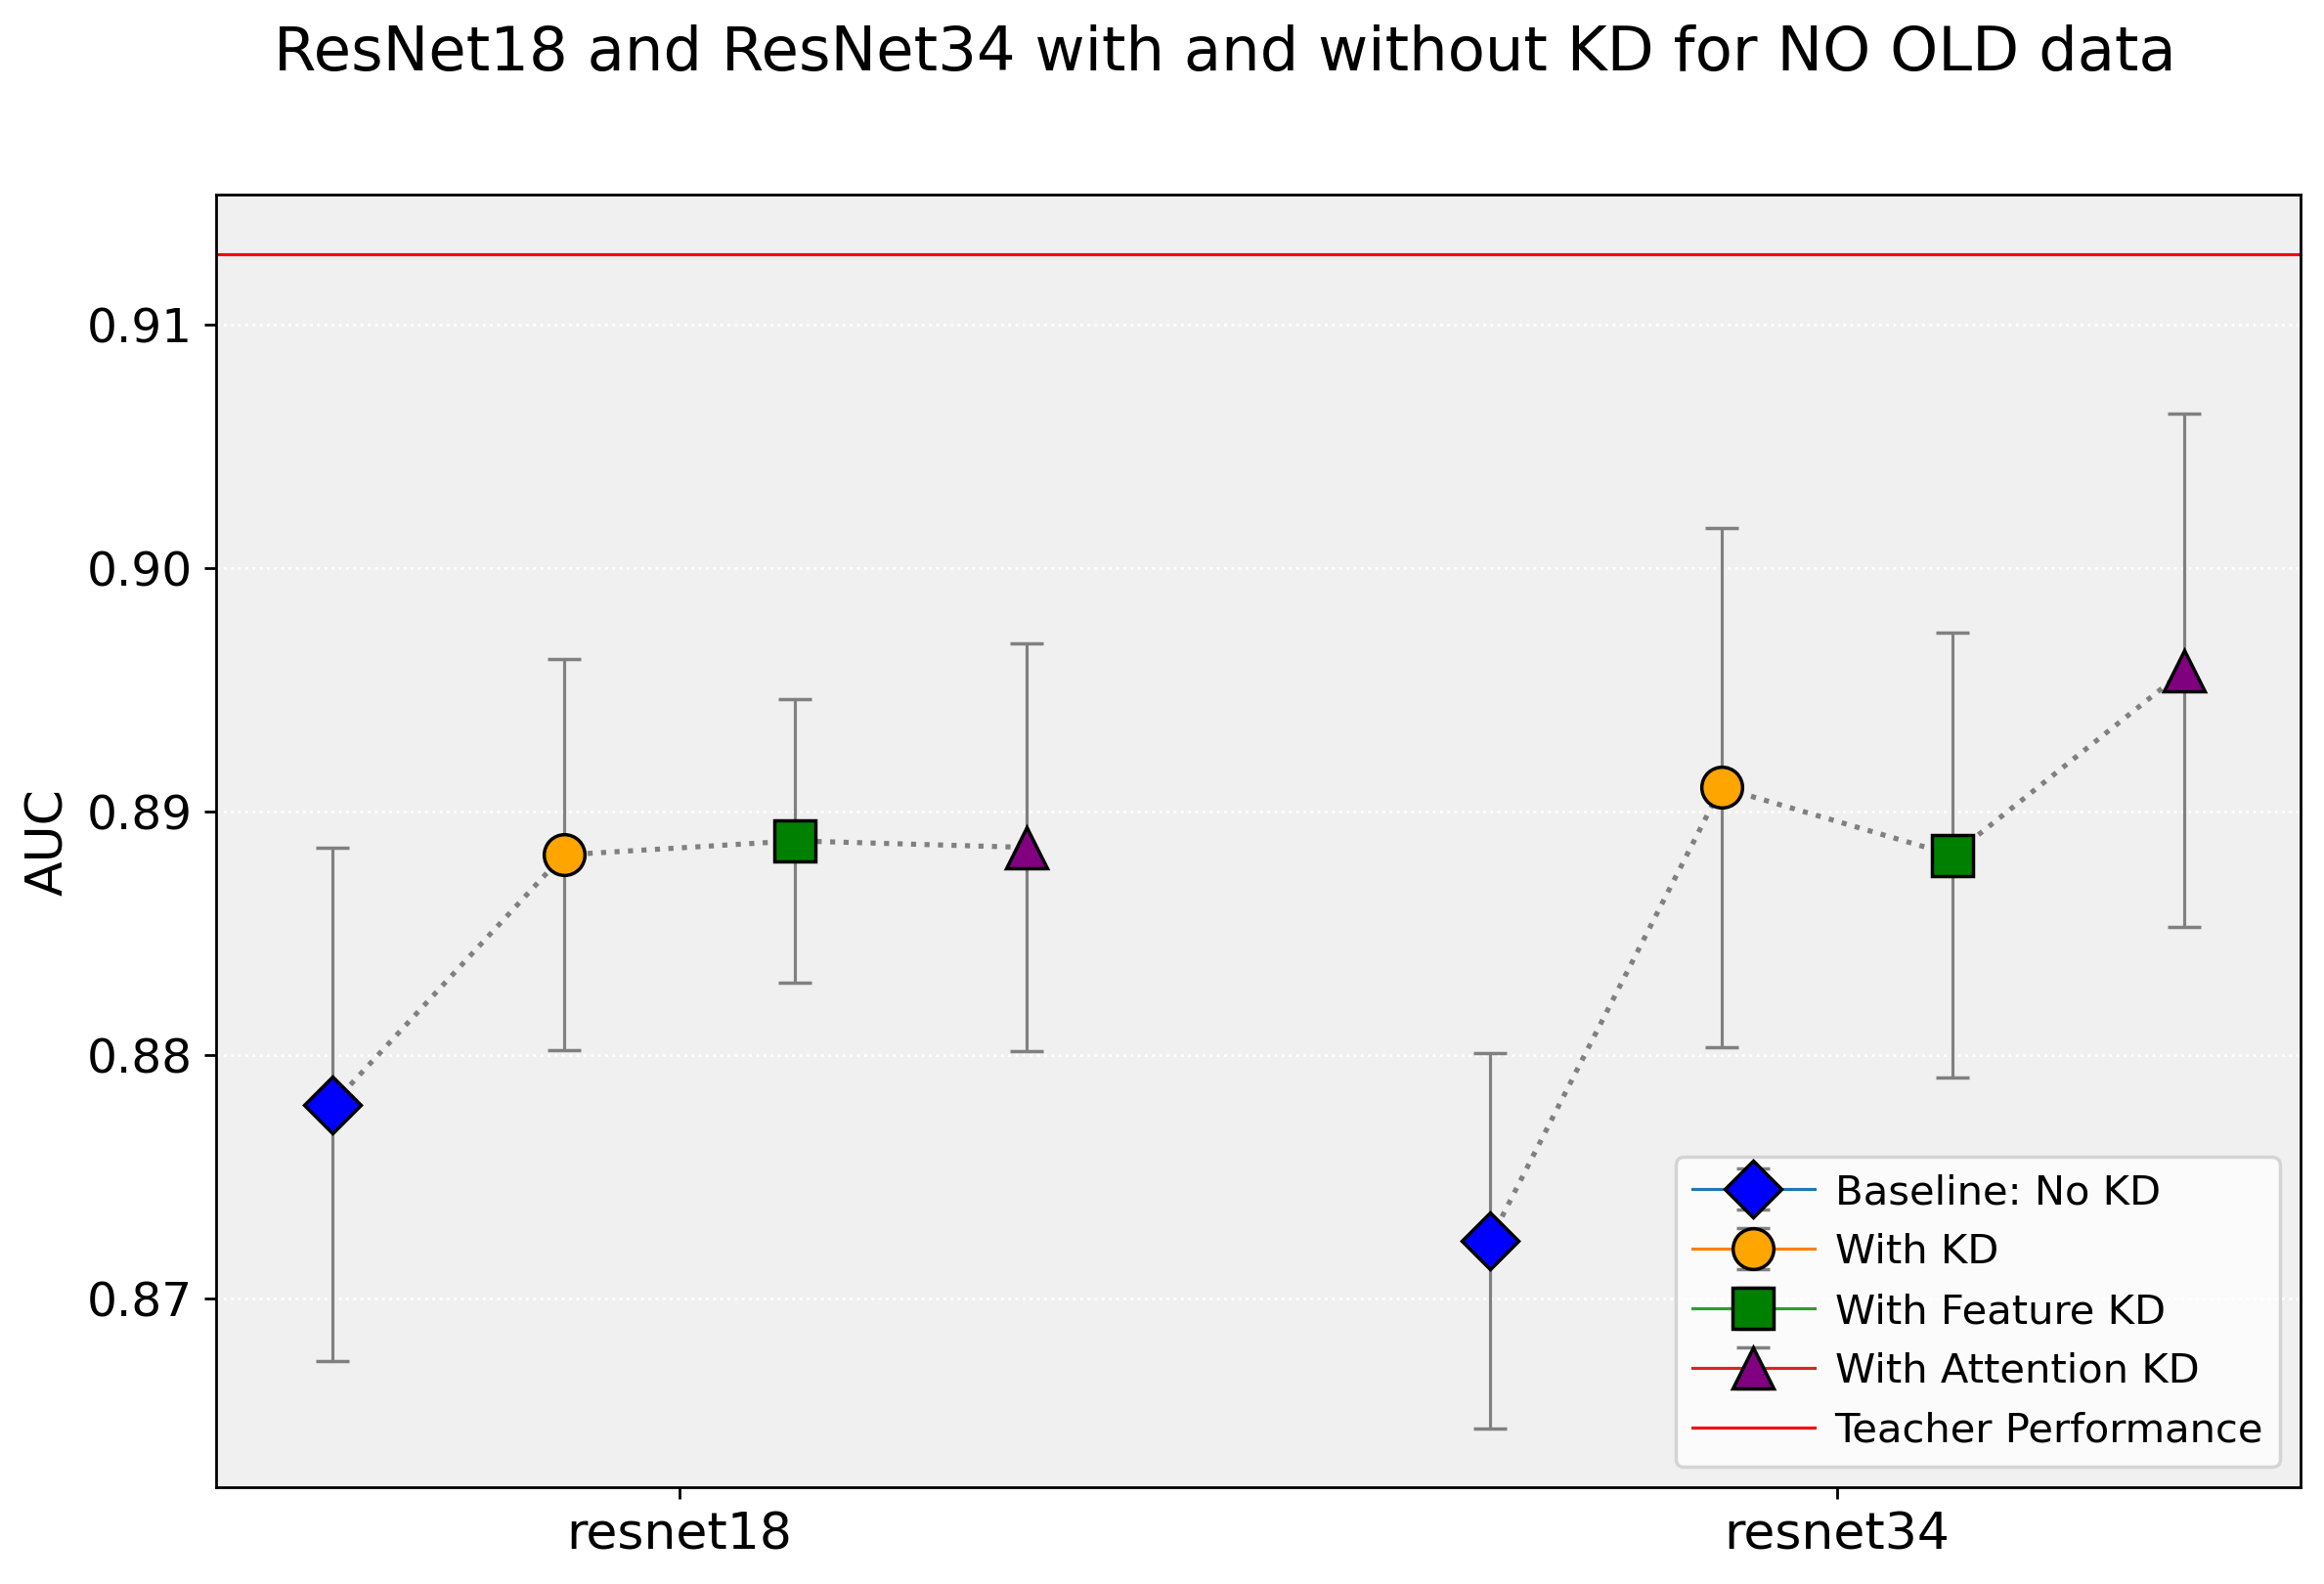

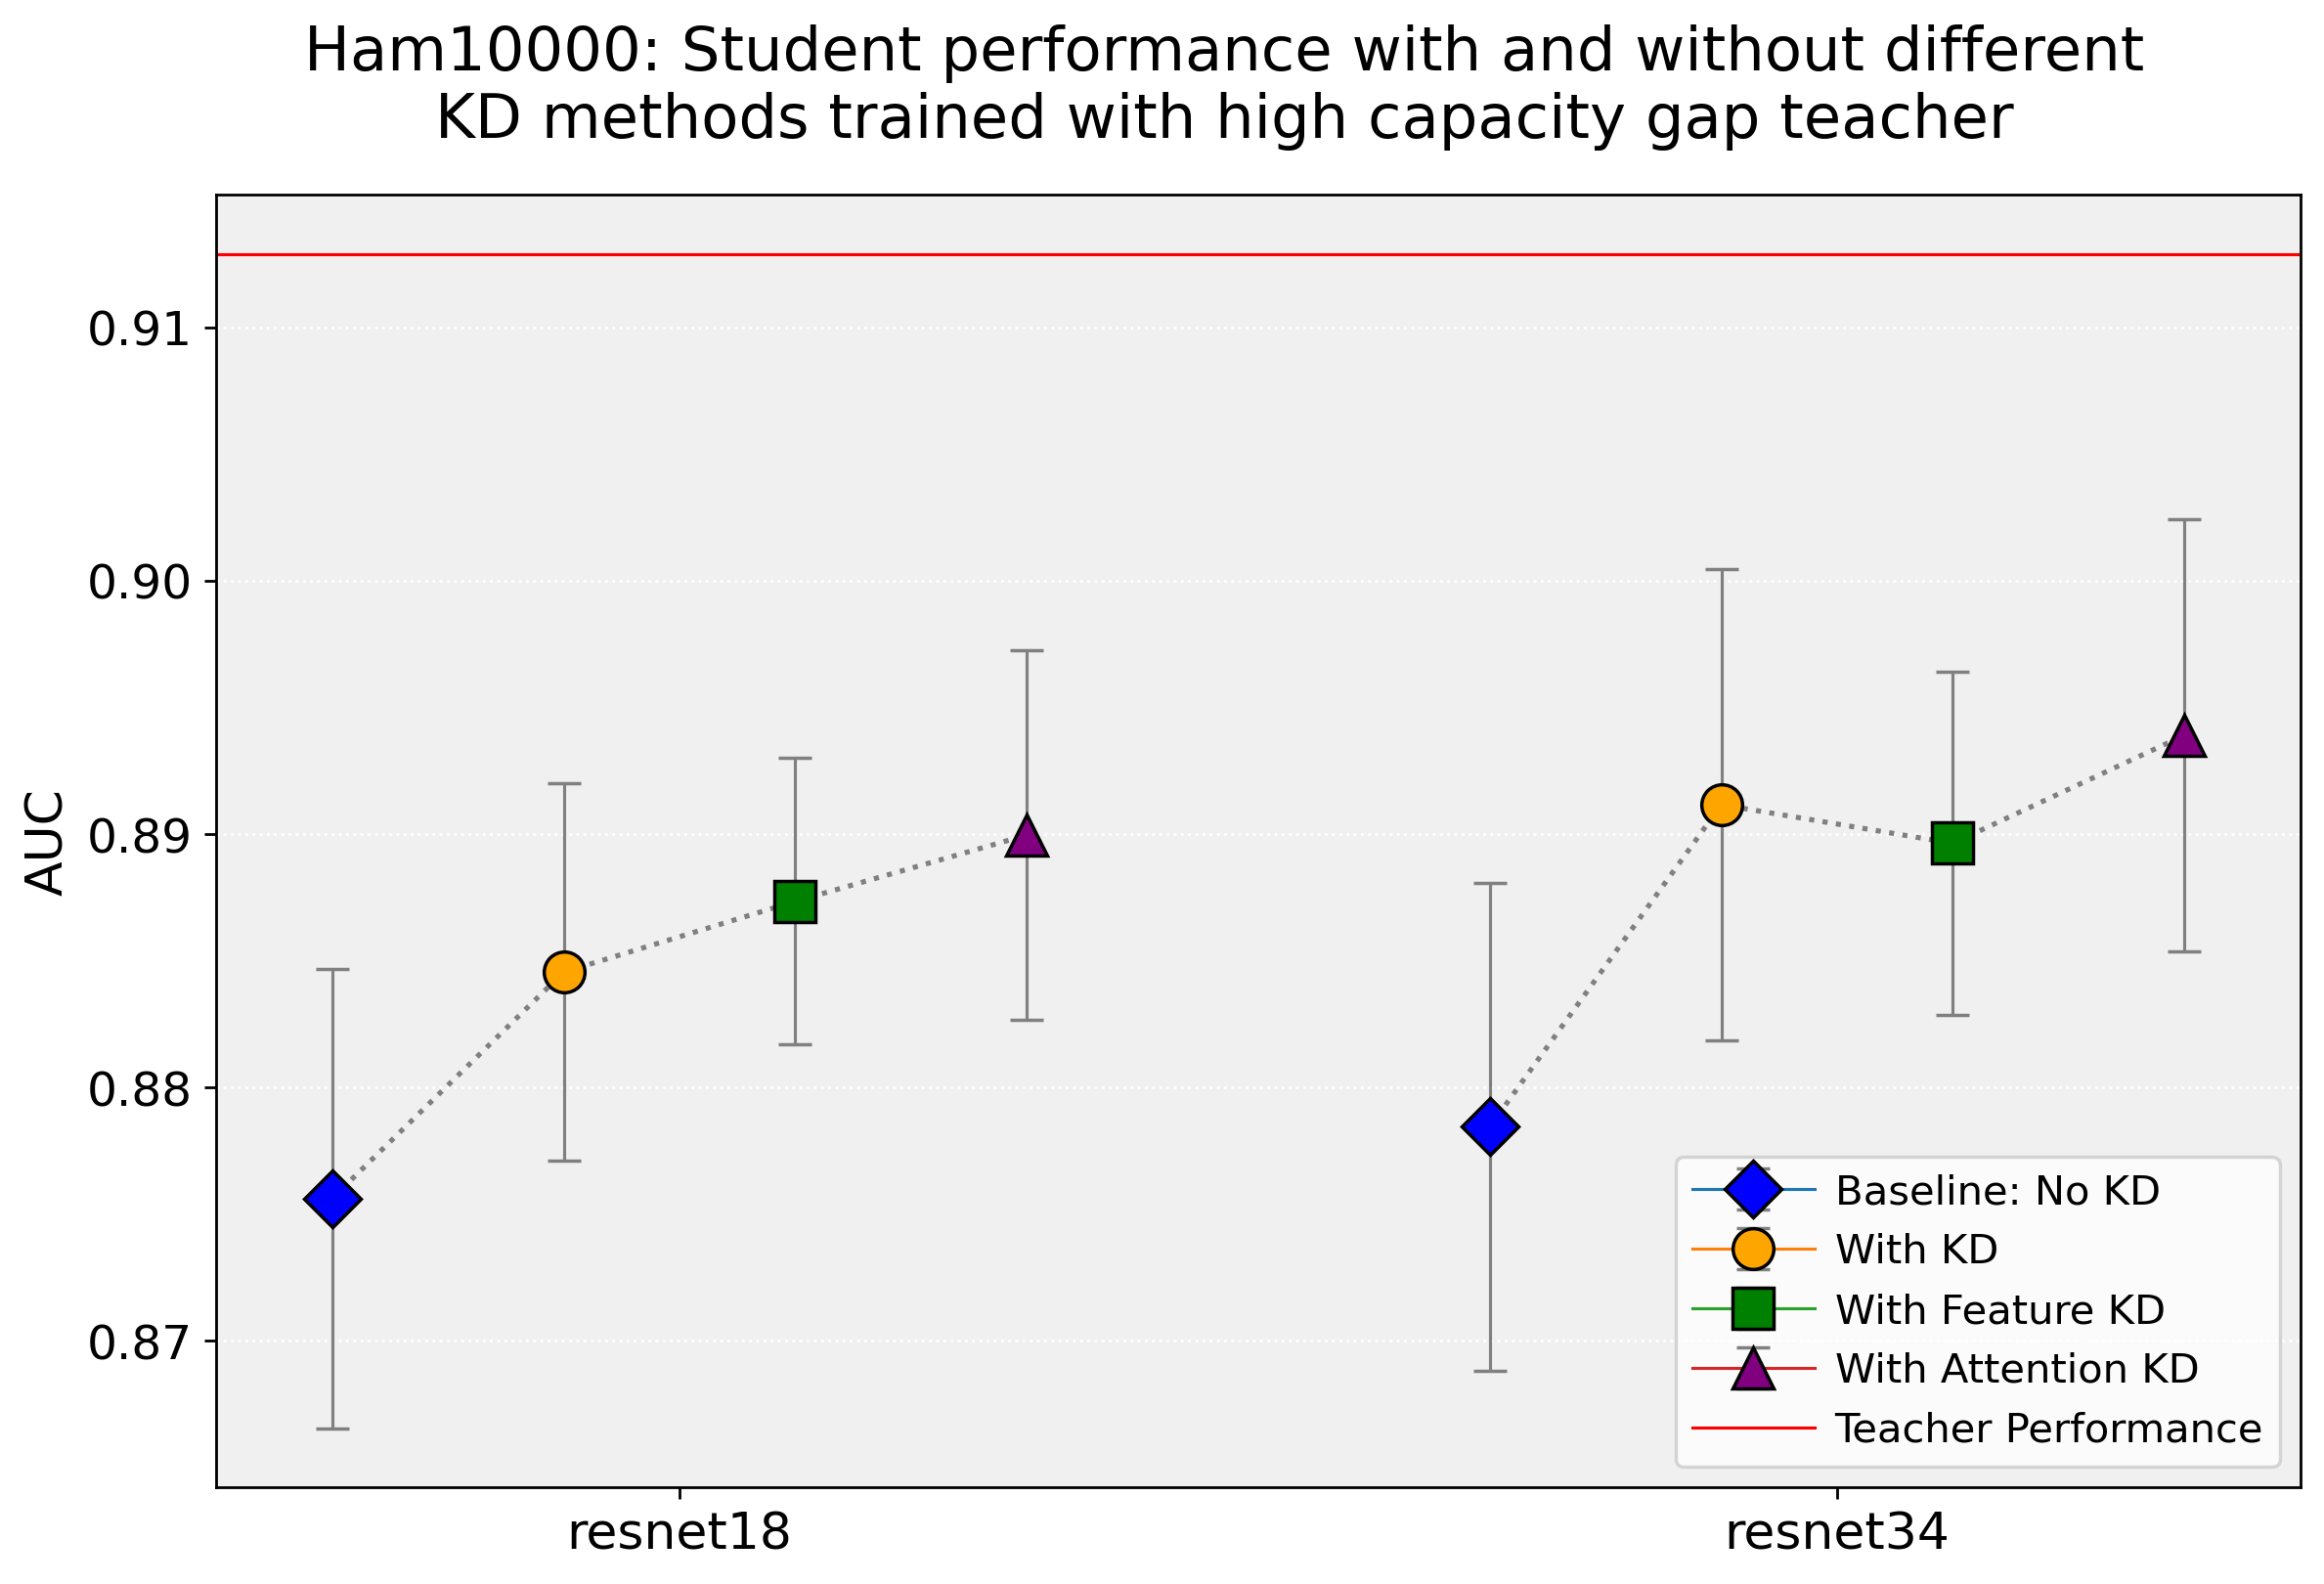

In [16]:
kd_overall_model_performance(
    no_female_df,
    kd_no_female_df,
    feature_no_female_df,
    attention_no_female_df,
    original_df,
    'r101-sam1-s42',
    'auc',
    title='ResNet18 and ResNet34 with and without KD for NO FEMALE data',
)

kd_overall_model_performance(
    no_old_df,
    kd_no_old_df,
    feature_no_old_df,
    attention_no_old_df,
    original_df,
    'r101-sam1-s42',
    'auc',
    title='ResNet18 and ResNet34 with and without KD for NO OLD data',
)

all_students_df = pd.concat([no_female_df, no_old_df])
all_students_kd_df = pd.concat([kd_no_female_df, kd_no_old_df])
all_students_feature_df = pd.concat([feature_no_female_df, feature_no_old_df])
all_students_attention_df = pd.concat([attention_no_female_df, attention_no_old_df])

kd_overall_model_performance(
    all_students_df,
    all_students_kd_df,
    all_students_feature_df,
    all_students_attention_df,
    original_df,
    'r101-sam1-s42',
    'auc',
    title='Ham10000: Student performance with and without different\nKD methods trained with high capacity gap teacher',
)

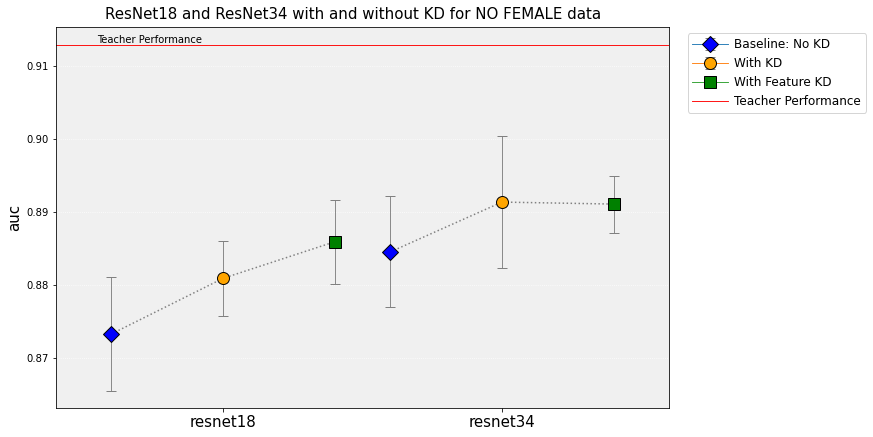

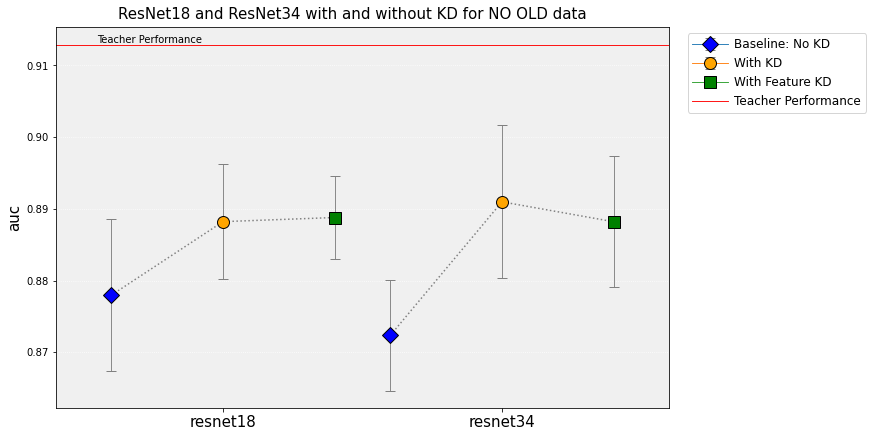

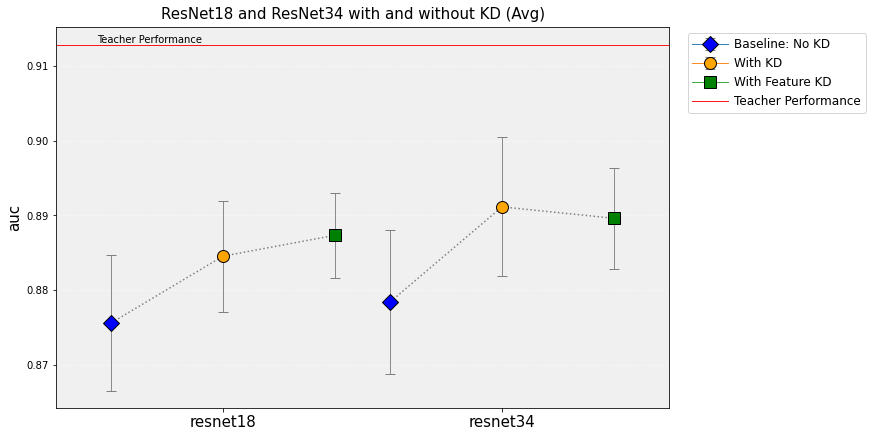

In [8]:
kd_overall_model_performance(
    no_female_df,
    kd_no_female_df,
    feature_no_female_df,
    original_df,
    'r101-sam1-s42',
    'auc',
    title='ResNet18 and ResNet34 with and without KD for NO FEMALE data',
)

kd_overall_model_performance(
    no_old_df,
    kd_no_old_df,
    feature_no_old_df,
    original_df,
    'r101-sam1-s42',
    'auc',
    title='ResNet18 and ResNet34 with and without KD for NO OLD data',
)

all_students_df = pd.concat([no_female_df, no_old_df])
all_students_kd_df = pd.concat([kd_no_female_df, kd_no_old_df])
all_students_feature_df = pd.concat([feature_no_female_df, feature_no_old_df])

kd_overall_model_performance(
    all_students_df,
    all_students_kd_df,
    all_students_feature_df,
    original_df,
    'r101-sam1-s42',
    'auc',
    title='ResNet18 and ResNet34 with and without KD (Avg)',
)

## Subgroup Disparities

In [29]:
experiment_colors = {
    "sex_no_kd": "#FFB6C1",
    "sex_kd": "#FF69B4",
    "sex_feature": "#800080",
    "sex_attention": "#4B0082",
    "age_no_kd": "#FFDFBA",
    "age_kd": "#FFA500",
    "age_feature": "#FF8C00",
    "age_attention": "#FF4500",
    "race_no_kd": "honeydew",
    "race_kd": "palegreen",
    "race_feature": "green",
    "race_attention": "darkgreen"
}



def kd_overall_model_subgroup_performance(
        resnet_df: pd.DataFrame,
        kd_df: pd.DataFrame,
        feature_df: pd.DataFrame,
        attention_df: pd.DataFrame,
        teacher_df: pd.DataFrame,
        subgroups: list[str],
        teacher_id: str,
        metric: str,
        title: str = '',
        bar_width=0.2, 
        line_length=0.05,
    ):

    kd_df = kd_df.sort_values(by=['model_name'])
    feature_df = feature_df.sort_values(by=['model_name'])
    attention_df = attention_df.sort_values(by=['model_name'])

    age_metric = 'age_' + metric
    sex_metric = 'sex_' + metric

    # Get teachers from resnet_df
    age_teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][age_metric][0]
    sex_teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][sex_metric][0]
                            
    # Set up graphical variables
    total_bars = 4
    bar_group_width = bar_width * total_bars
    legend_handles = []
    legend_labels = []

    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create the plot
    for i, model in enumerate(kd_df['model_name'].unique()):
        for j, subgroup in enumerate(subgroups):
            model_scores = []
            subgroup_metric = subgroup + "_" + metric

            # Get without KD
            scores = resnet_df[(resnet_df['model_name'] == model)][subgroup_metric]
            mean_score = scores.mean()
            std_error = scores.std()
            model_scores.append(mean_score)
            x_pos_no_kd = i - bar_group_width/2 + (0 + 0.5) * bar_width
            handle_no_kd = ax.errorbar(x_pos_no_kd, mean_score, yerr=std_error, marker='D', capsize=5, markersize=12, markerfacecolor=experiment_colors[f'{subgroup}_no_kd'], markeredgecolor='black', ecolor='gray', linewidth=0.9)
            if f'{subgroup.capitalize()} w/o KD' not in legend_labels:
                legend_handles.append(handle_no_kd)
                legend_labels.append(f'{subgroup.capitalize()} w/o KD')

            # Get with KD
            scores = kd_df[(kd_df['model_name'] == model)][subgroup_metric]
            mean_score = scores.mean()
            std_error = scores.std()
            model_scores.append(mean_score)
            x_pos_kd = i - bar_group_width/2 + (1 + 0.5) * bar_width
            handle_kd = ax.errorbar(x_pos_kd, mean_score, yerr=std_error, marker='o', capsize=5, markersize=12, markerfacecolor=experiment_colors[f'{subgroup}_kd'], markeredgecolor='black', ecolor='gray', linewidth=0.9)
            if f'{subgroup.capitalize()} w/ Response KD' not in legend_labels:
                legend_handles.append(handle_kd)
                legend_labels.append(f'{subgroup.capitalize()} w/ Response KD')

            # Get with Feature KD
            scores = feature_df[(feature_df['model_name'] == model)][subgroup_metric]
            mean_score = scores.mean()
            std_error = scores.std()
            model_scores.append(mean_score)
            x_pos_feature_kd = i - bar_group_width/2 + (2 + 0.5) * bar_width
            handle_feature_kd = ax.errorbar(x_pos_feature_kd, mean_score, yerr=std_error, marker='s', capsize=5, markersize=12, markerfacecolor=experiment_colors[f'{subgroup}_feature'], markeredgecolor='black', ecolor='gray', linewidth=0.9)
            if f'{subgroup.capitalize()} w/ Feature KD' not in legend_labels:
                legend_handles.append(handle_feature_kd)
                legend_labels.append(f'{subgroup.capitalize()} w/ Feature KD')

            # Get with Attention KD
            scores = attention_df[(attention_df['model_name'] == model)][subgroup_metric]
            mean_score = scores.mean()
            std_error = scores.std()
            model_scores.append(mean_score)
            x_pos_attention_kd = i - bar_group_width/2 + (3 + 0.5) * bar_width
            handle_attention_kd = ax.errorbar(x_pos_attention_kd, mean_score, yerr=std_error, marker='^', capsize=5, markersize=12, markerfacecolor=experiment_colors[f'{subgroup}_attention'], markeredgecolor='black', ecolor='gray', linewidth=0.9)
            if f'{subgroup.capitalize()} w/ Attention KD' not in legend_labels:
                legend_handles.append(handle_attention_kd)
                legend_labels.append(f'{subgroup.capitalize()} w/ Attention KD')

            # Draw a dotted line between No KD and KD
            ax.plot([x_pos_no_kd, x_pos_kd, x_pos_feature_kd, x_pos_attention_kd], [model_scores[0], model_scores[1], model_scores[2], model_scores[3]], linestyle=':', color='grey')
            # ax.plot([x_pos_no_kd, x_pos_kd, x_pos_feature_kd], [model_scores[0], model_scores[1], model_scores[2]], linestyle=':', color='grey')


    # Show Teacher performance:
    teacher_age = ax.axhline(y=age_teacher_performance, linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='red')
    legend_handles.append(teacher_age)
    legend_labels.append('Age Teacher')

    teacher_sex = ax.axhline(y=sex_teacher_performance, linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='violet')
    legend_handles.append(teacher_sex)
    legend_labels.append('Sex Teacher')

    # Add text above the teacher performance line
    # ax.text(0.4, age_teacher_performance, 'Age Teacher', color='black', va='bottom')
    # ax.text(0.4, sex_teacher_performance, 'Sex Teacher', color='black', va='bottom')

    # Customize the plot
    ax.set_xticks(np.arange(len(kd_df['model_name'].unique())))
    ax.set_xticklabels(kd_df['model_name'].unique(), fontsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylabel('Avg AUC Gap', fontsize=16) 
    # Set the x-axis limits to show all the error bars
    ax.set_xlim(-bar_group_width/2, len(kd_df['model_name'].unique())-1+bar_group_width/2)
    ax.set_facecolor('#F0F0F0')

    # Set legend title
    legend = ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', handlelength=3.0, handletextpad=0.5, prop={'size': 14}, labelspacing=0.8)
    legend.set_title('Subgroup AUC Gap', prop={'size': 15})
    # legend's face color:
    legend.get_frame().set_facecolor('#F0F0F0')
    # legend's border color:
    legend.get_frame().set_edgecolor('black')
    # set legend's opacity
    legend.get_frame().set_alpha(1)

    
    # Grid
    ax.yaxis.grid(True, linestyle='dotted', linewidth=0.8, color='white', alpha=1)
    # Title
    fig.suptitle(title, fontsize=20, y=0.97)

    # plt.show()

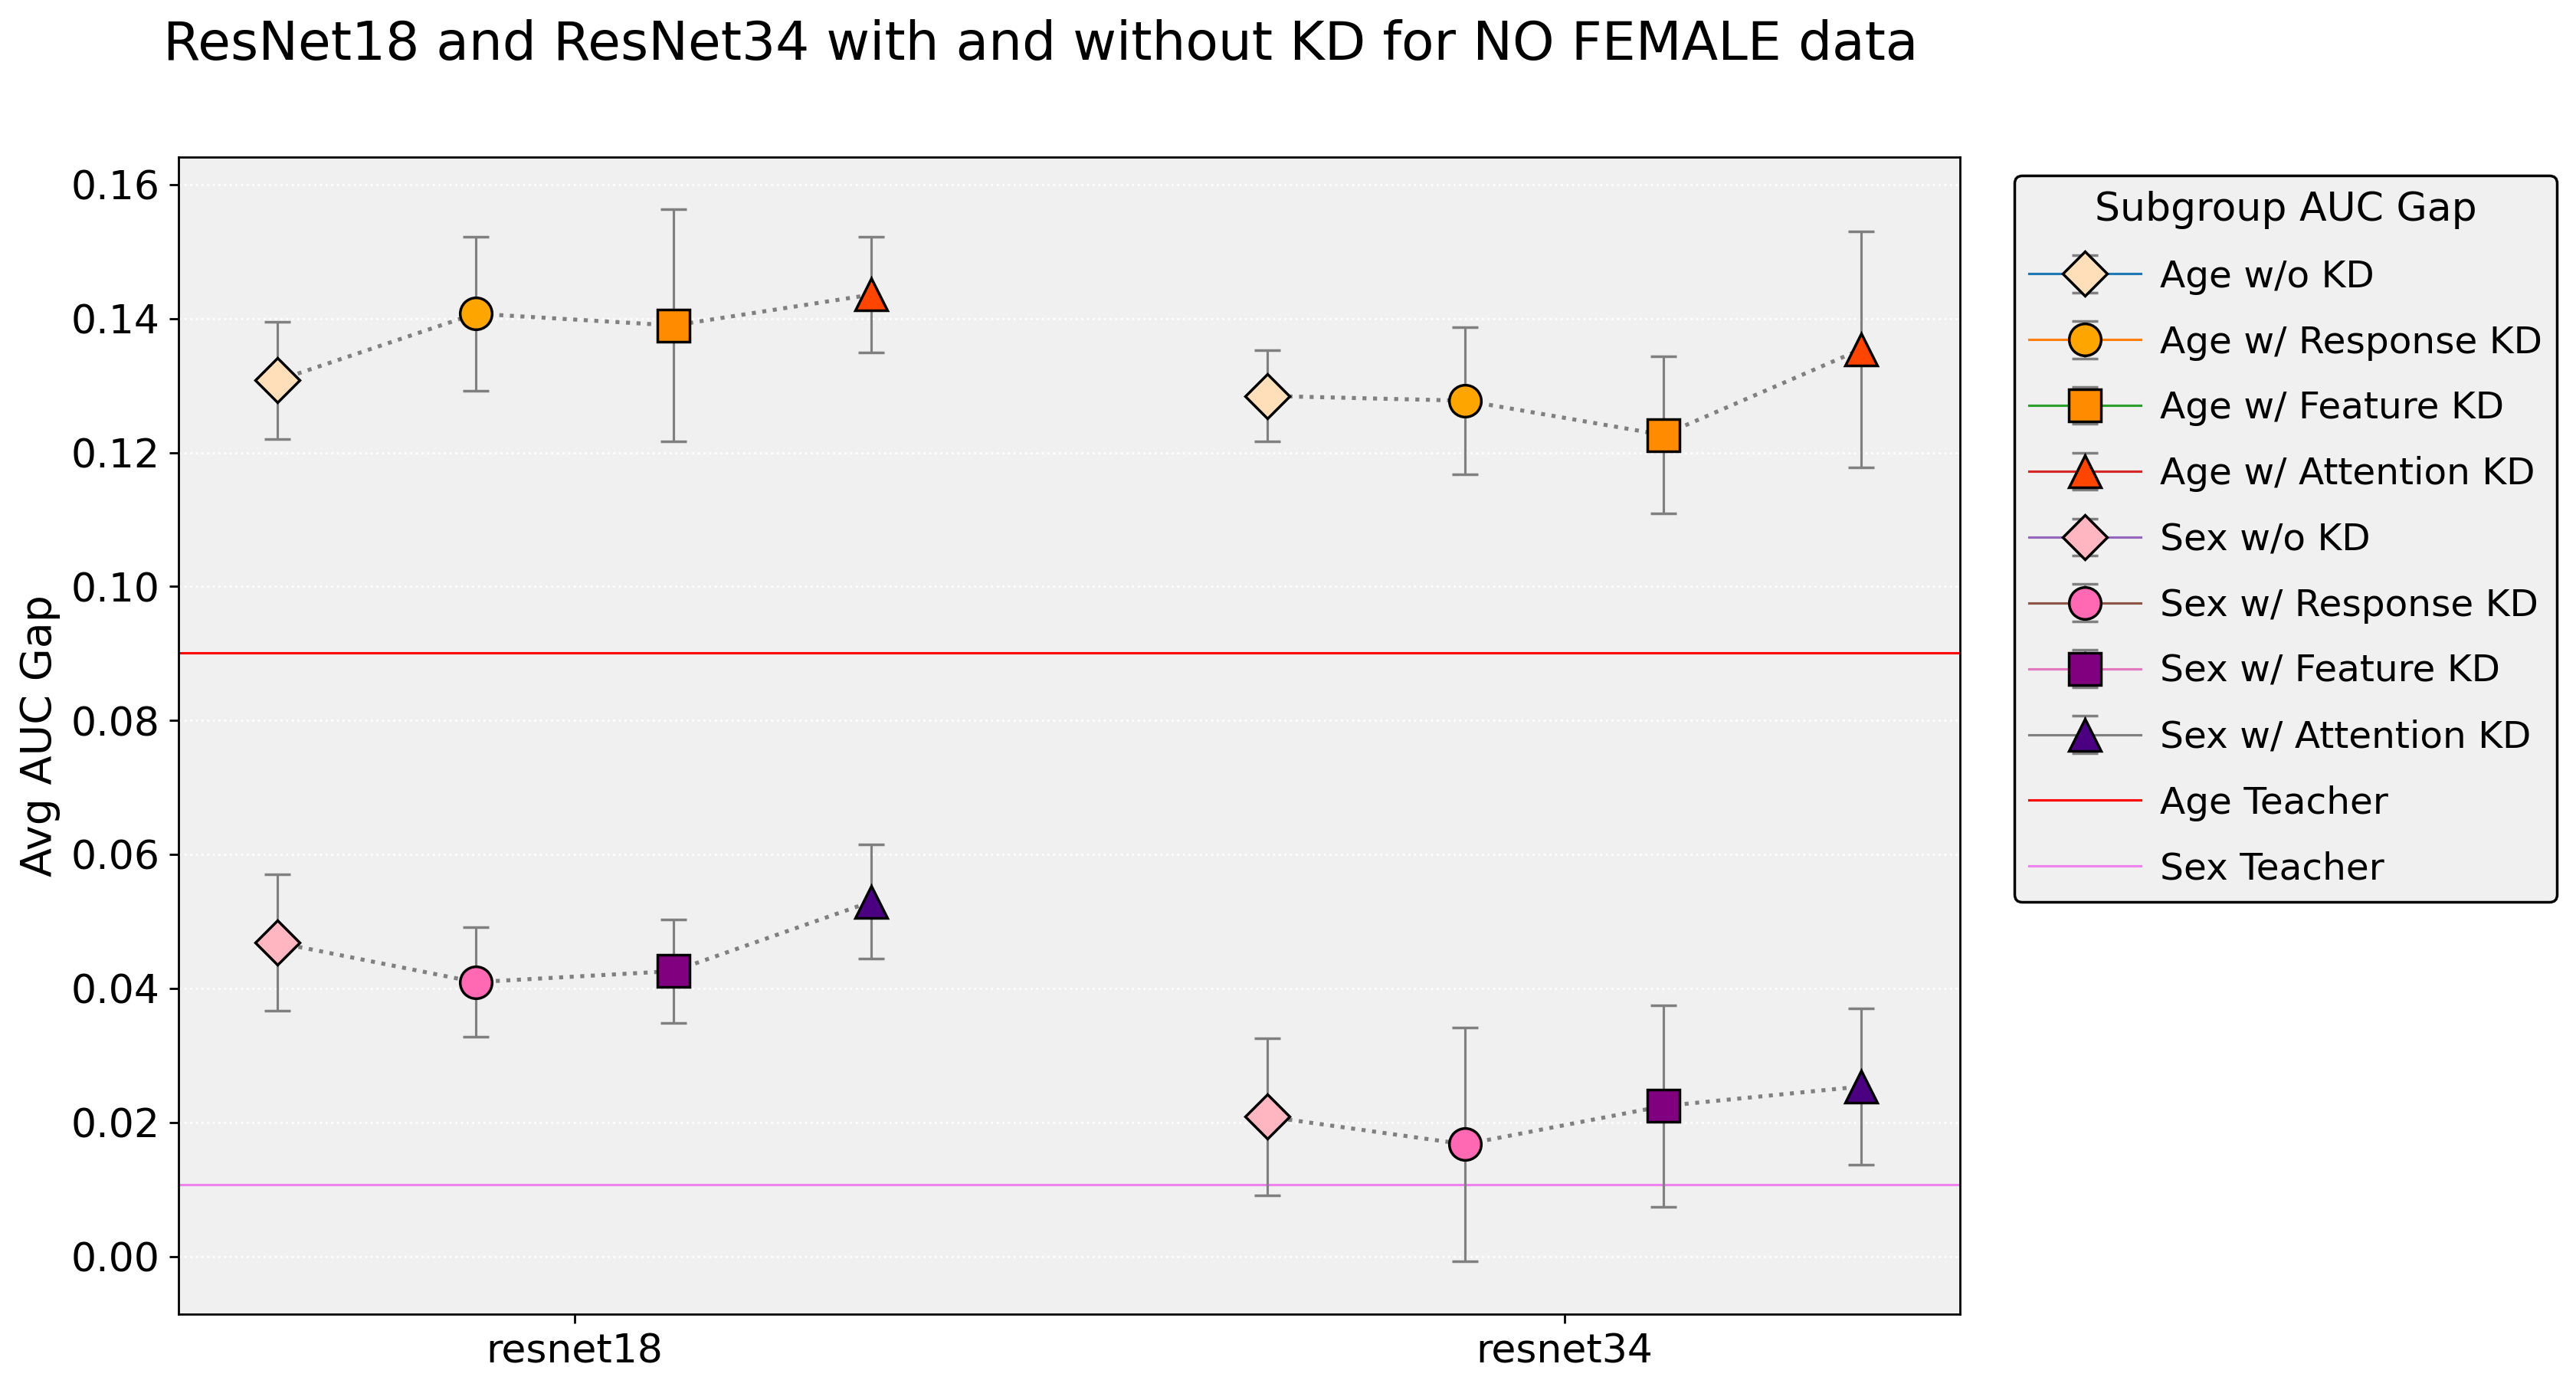

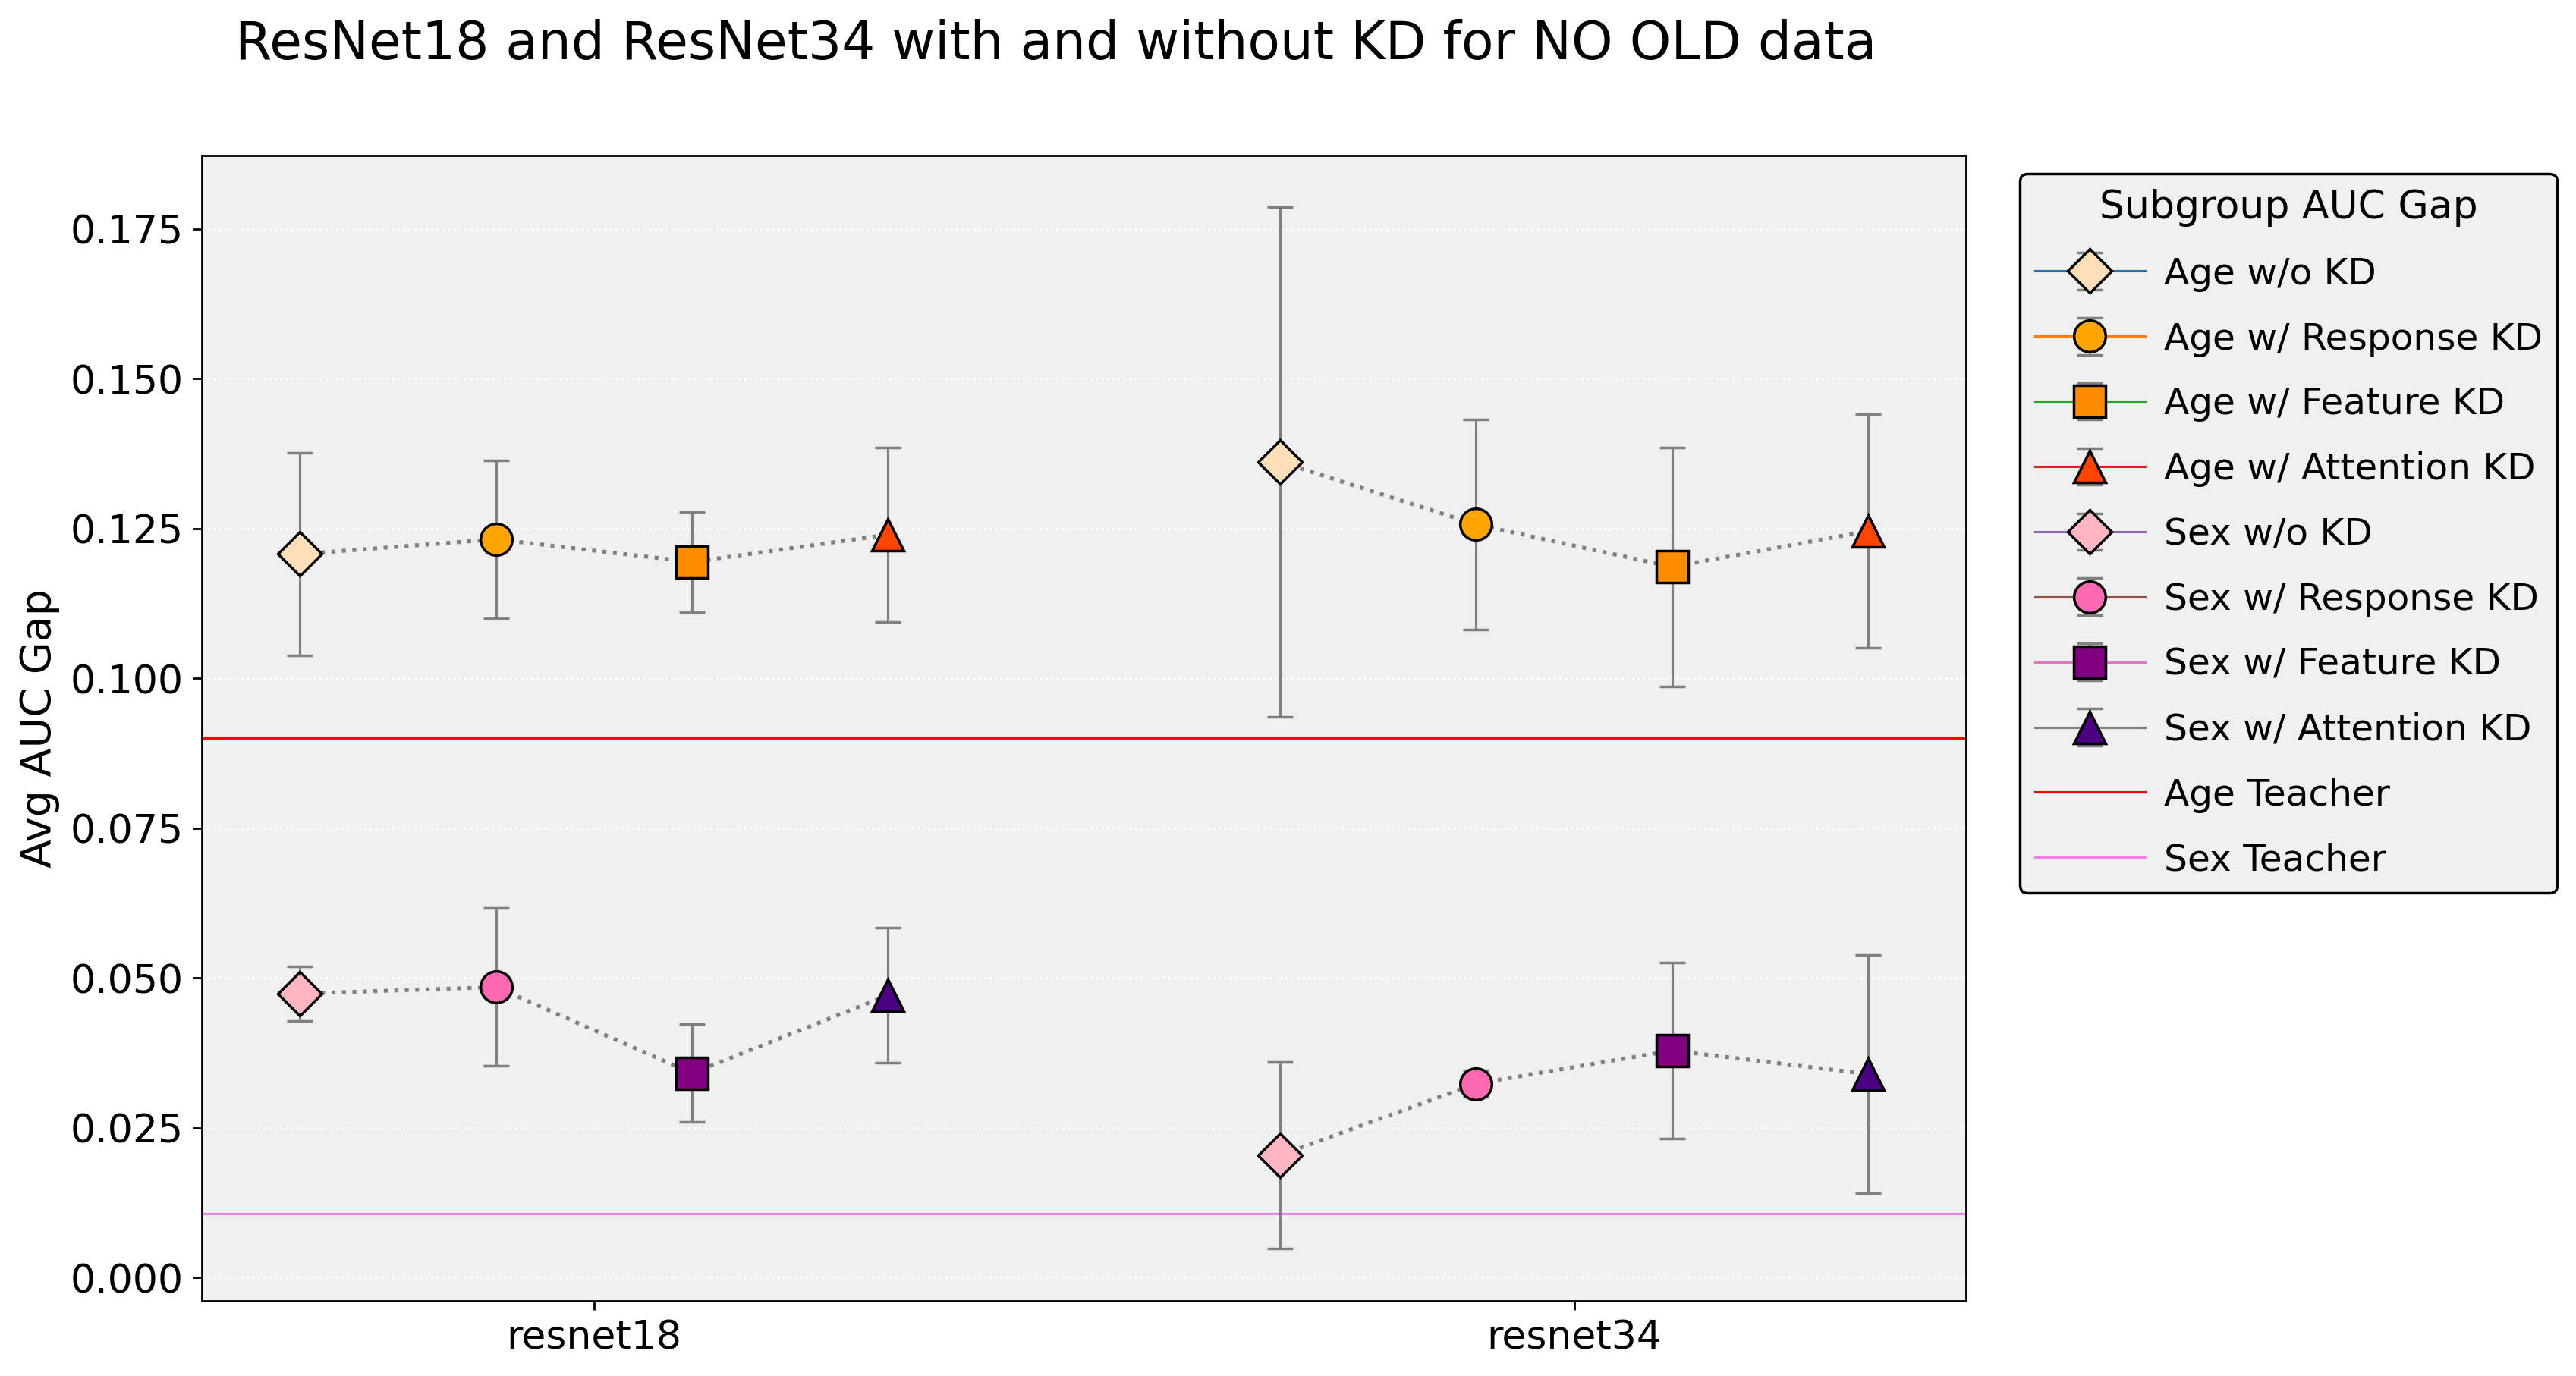

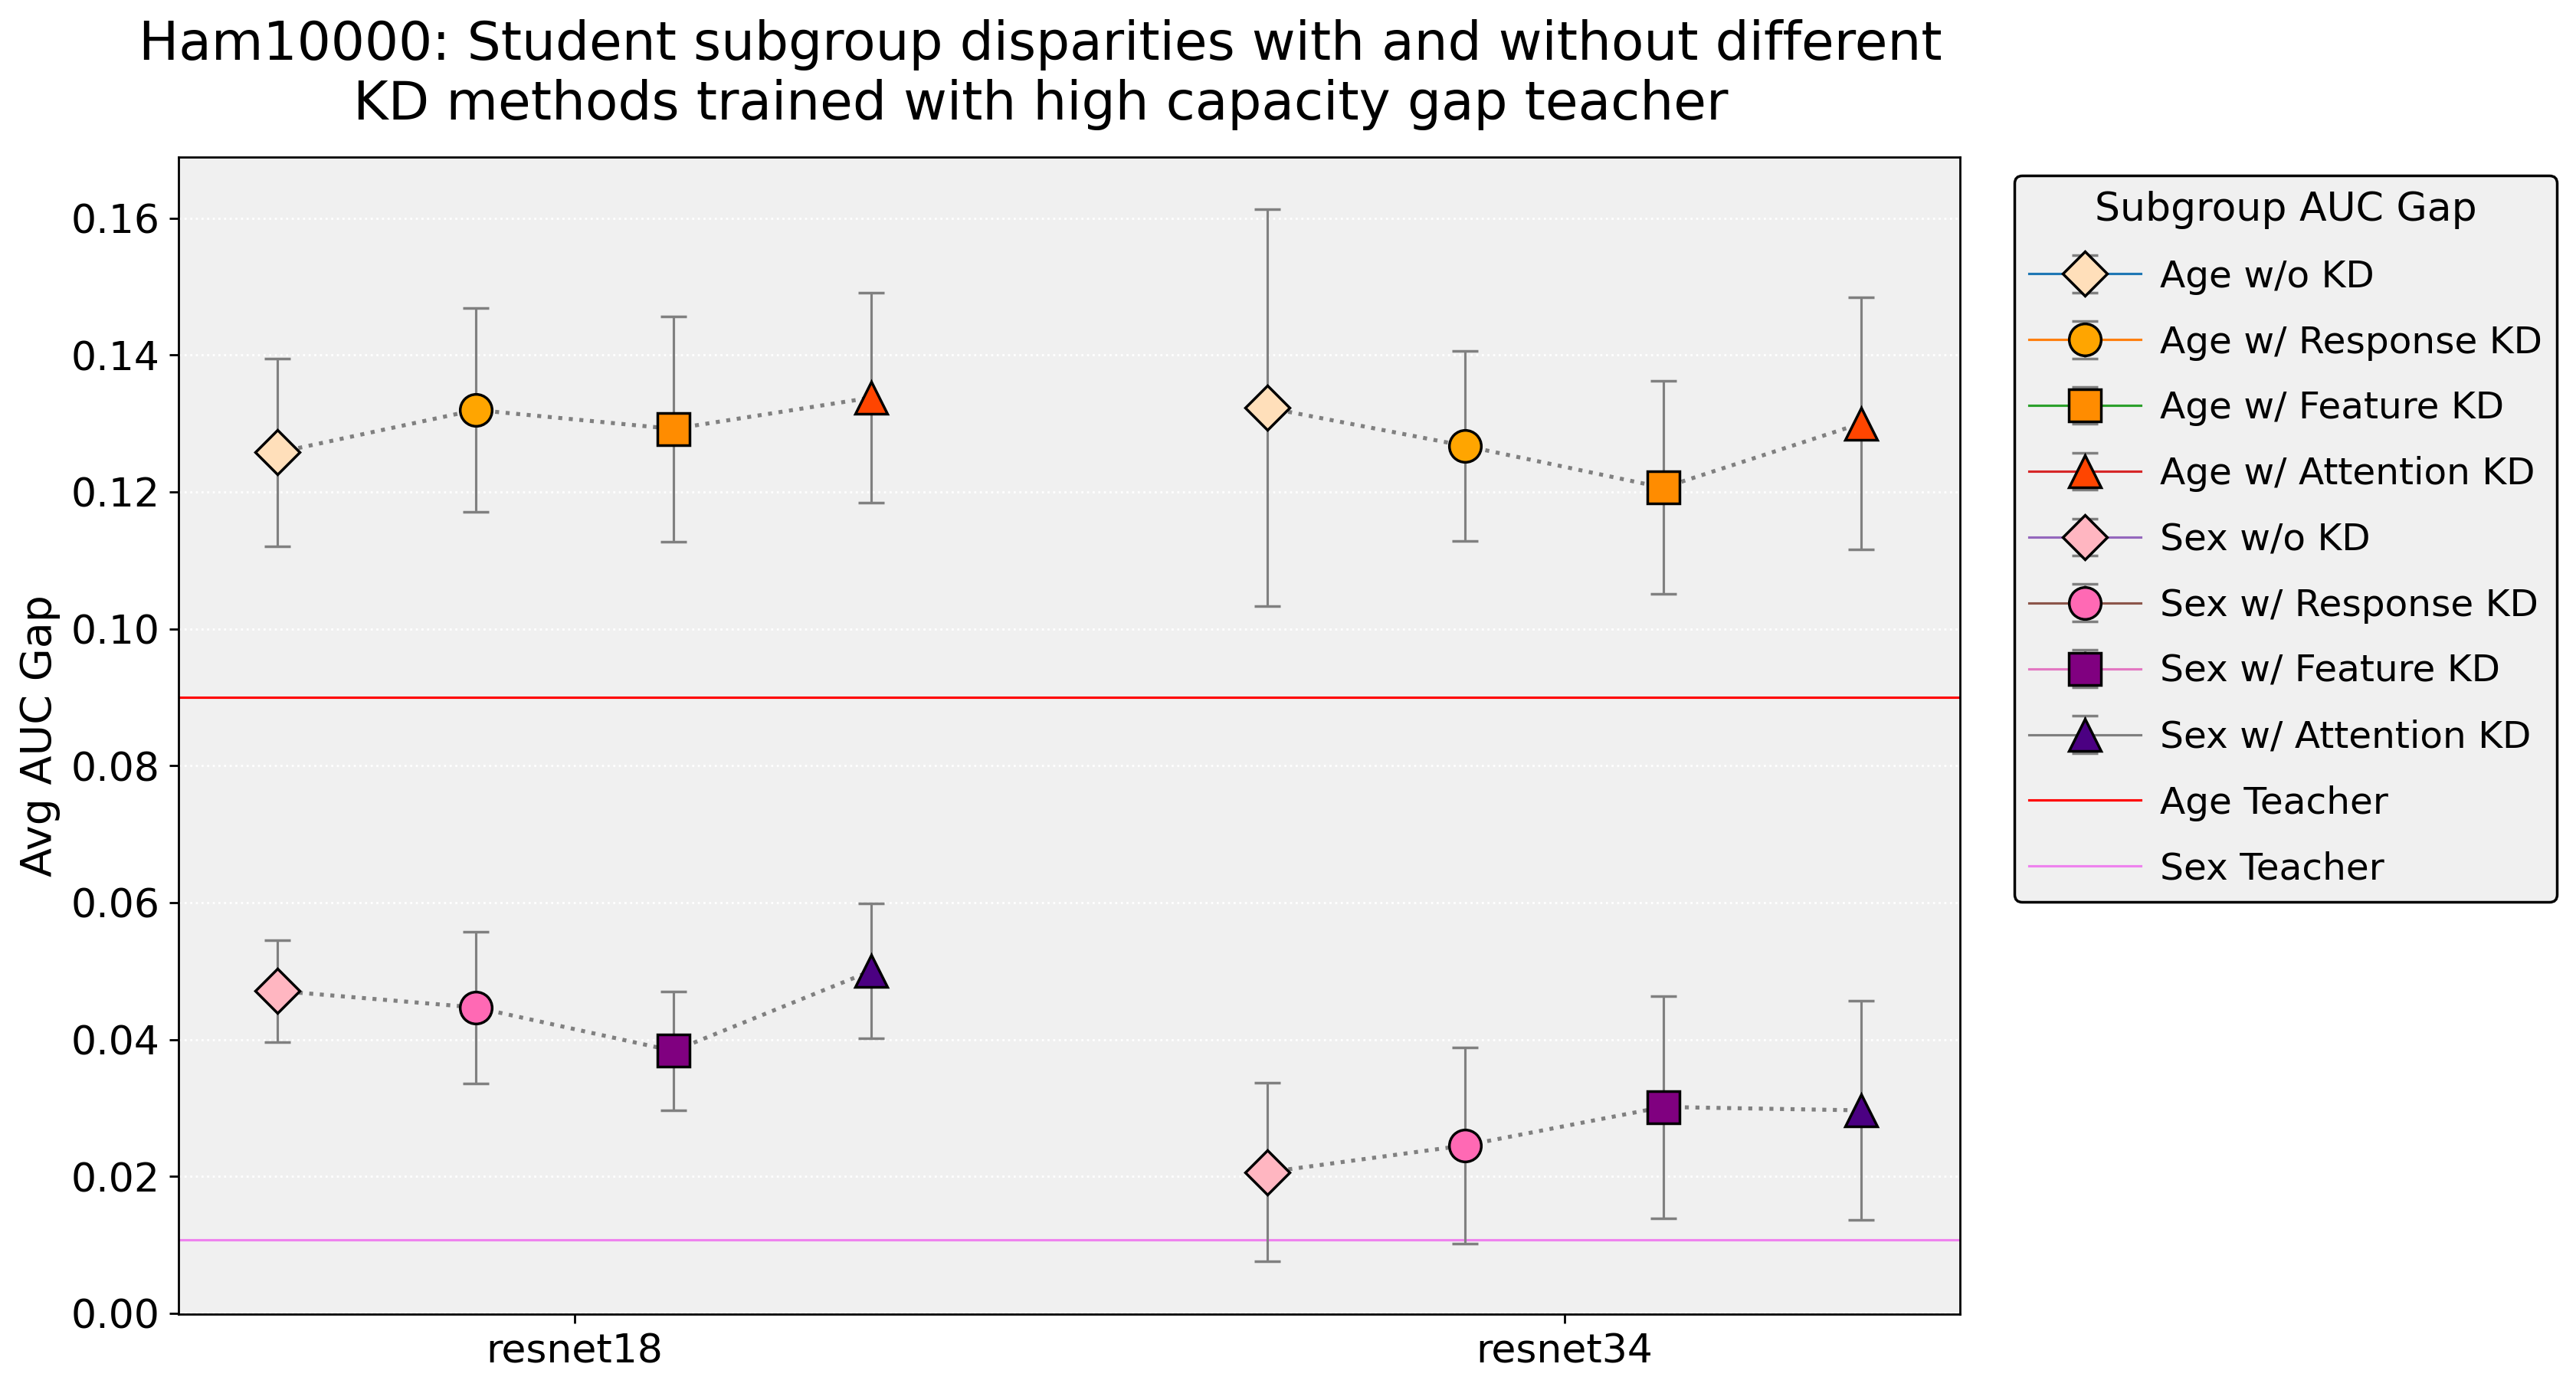

In [30]:
kd_overall_model_subgroup_performance(
    no_female_df,
    kd_no_female_df,
    feature_no_female_df,
    attention_no_female_df,
    original_df,
    ['age', 'sex'],
    'r101-sam1-s42',
    'auc_gap_relative',
    title='ResNet18 and ResNet34 with and without KD for NO FEMALE data',
)

kd_overall_model_subgroup_performance(
    no_old_df,
    kd_no_old_df,
    feature_no_old_df,
    attention_no_old_df,
    original_df,
    ['age', 'sex'],
    'r101-sam1-s42',
    'auc_gap_relative',
    title='ResNet18 and ResNet34 with and without KD for NO OLD data',
)


kd_overall_model_subgroup_performance(
    all_students_df,
    all_students_kd_df,
    all_students_feature_df,
    all_students_attention_df,
    original_df,
    ['age', 'sex'],
    'r101-sam1-s42',
    'auc_gap_relative',
    title='Ham10000: Student subgroup disparities with and without different\nKD methods trained with high capacity gap teacher',
)

## Radar Chart

In [11]:
from typing import List
metric_names = {
    'auc': 'AUC',
    'age_auc_group_0': 'Age < 60 AUC',
    'age_auc_group_1': 'Age 60+ AUC',
    'sex_auc_group_0': 'Male AUC',
    'sex_auc_group_1': 'Female AUC',
    'race_auc_group_0': 'White AUC',
    'race_auc_group_1': 'Non-White AUC',
    'avg_auc_gap': 'Avg AUC Gap',
    'age_auc_gap': 'Age AUC Gap',
    'sex_auc_gap': 'Sex AUC Gap',
    'race_auc_gap': 'Race AUC Gap',
    'age_eq_odds': 'Age Eq. Odds',
    'sex_eq_odds': 'Sex Eq. Odds',
    'race_eq_odds': 'Race Eq. Odds',
}

def overall_radar_plot(
    resnet_df: pd.DataFrame, # baseline
    kd_df: pd.DataFrame,    # kd results
    feature_df: pd.DataFrame, 
    original_df: pd.DataFrame, # df to take the teacher performance from
    metrics: List[str],
    teacher_id: str,
    student_model: str, # resnet18 or resnet34
    title: str = 'title',
    is_performance: bool = True,
):
    # get the teacher performance
    teacher_df = original_df[original_df['model_id'] == teacher_id]
    teacher_df = teacher_df[metrics]
    teacher_df = teacher_df.rename(columns=metric_names)
    teacher_df = teacher_df.melt(var_name='metric', value_name='value')

    # get the average baseline performance by model
    student_baseline = resnet_df[resnet_df['model_name'] == student_model]
    student_baseline = student_baseline[metrics]
    student_baseline = student_baseline.rename(columns=metric_names)
    student_baseline = student_baseline.mean().to_frame().T
    student_baseline = student_baseline.melt(var_name='metric', value_name='value')
    
    # get the average kd performance by model
    student_kd = kd_df[(kd_df['model_name'] == student_model) & (kd_df['teacher_id'] == teacher_id)]
    student_kd = student_kd[metrics]
    student_kd = student_kd.rename(columns=metric_names)
    student_kd = student_kd.mean().to_frame().T
    student_kd = student_kd.melt(var_name='metric', value_name='value')

    # get the average feature kd performance by model
    feature_kd = feature_df[(feature_df['model_name'] == student_model) & (feature_df['teacher_id'] == teacher_id)]
    feature_kd = feature_kd[metrics]
    feature_kd = feature_kd.rename(columns=metric_names)
    feature_kd = feature_kd.mean().to_frame().T
    feature_kd = feature_kd.melt(var_name='metric', value_name='value')

    # Add last element to create a circular effect
    teacher_df = teacher_df.append(teacher_df.iloc[0], ignore_index=True) 
    student_baseline = student_baseline.append(student_baseline.iloc[0], ignore_index=True) 
    student_kd = student_kd.append(student_kd.iloc[0], ignore_index=True) 
    feature_kd = feature_kd.append(feature_kd.iloc[0], ignore_index=True)

    fig = go.Figure()
    fig = px.line_polar(start_angle=90)

    # PERFORMANCE
    if is_performance:
        fig.add_trace(go.Scatterpolar(
            r=teacher_df['value'],
            theta=teacher_df['metric'],
            name='Teacher',
            # line_color='#FFB6C1'
        ))
        fig.add_trace(go.Scatterpolar(
            r=feature_kd['value'],
            theta=feature_kd['metric'],
            name=f'{student_model.capitalize()} w/ Feature KD',
            # line_color='blue'
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_kd['value'],
            theta=student_kd['metric'],
            name=f'{student_model.capitalize()} w/ Vanilla KD',
            # line_color='limegreen'
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_baseline['value'],
            theta=student_baseline['metric'],
            name=f'{student_model.capitalize()} w/o KD',
            line_color='bisque'
        ))
        fig.update_layout(
        width=800,  # Set the width of the plot (in pixels)
        height=600,  # Set the height of the plot (in pixels)
        title={
            'text': title,
            'x': 0.5,  # Align the title in the center
            'y': 1.0,  # Adjust the vertical position of the title
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 14}  # Adjust the font size of the title
        },
        polar=dict(
            radialaxis=dict(
            visible=True,
            range=[0.75, 0.95],
            tickvals=list(np.arange(0.8, 9.0, 0.05)),  # Specify the position where ticks appear
            ticktext=[str(round(i, 2)) for i in np.arange(0.8, 9.0, 0.05)]
            ),
        ),
            showlegend=True,
        )

    # FAIRNESS
    else:
        fig.add_trace(go.Scatterpolar(
            r=student_baseline['value'],
            theta=student_baseline['metric'],
            name=f'{student_model.capitalize()} w/o KD',
            line_color='#AB63FA'
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_kd['value'],
            theta=student_kd['metric'],
            name=f'{student_model.capitalize()} w/ KD',
            line_color='#00CC96'
        ))
        fig.add_trace(go.Scatterpolar(
            r=teacher_df['value'],
            theta=teacher_df['metric'],
            name='Teacher',
            line_color='#EF553B'
        ))
        fig.update_layout(
        width=800,  # Set the width of the plot (in pixels)
        height=600,  # Set the height of the plot (in pixels)
        title={
            'text': title,
            'x': 0.5,  # Align the title in the center
            'y': 0.95,  # Adjust the vertical position of the title
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 14}  # Adjust the font size of the title
        },
        polar=dict(
            radialaxis=dict(
            visible=True,
            # range=[0.0, 0.15],
            # tickvals=list(np.arange(0.75, 1.0, 0.05)),  # Specify the position where ticks appear
            ),
        ),
            showlegend=True,
        )

    fig.update_traces(fill='toself')
    fig.show()

    # 1. Teacher
    # 2. W/o KD
    # 3. W/ KD
    # 4. Feature KD


In [12]:
#### NO FEMALE DATASET #####
# OVERALL + SUBGROUP PERFORMANCE
overall_radar_plot(
    no_female_df,
    kd_no_female_df,
    feature_no_female_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    'r101-sam1-s42',
    student_model='resnet18',
    title='ResNet18 NO FEMALE dataset'
)

overall_radar_plot(
    no_female_df,
    kd_no_female_df,
    feature_no_female_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    'r101-sam1-s42',
    student_model='resnet34',
    title='ResNet34 NO FEMALE dataset'
)

overall_radar_plot(
    no_old_df,
    kd_no_old_df,
    feature_no_old_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    'r101-sam1-s42',
    student_model='resnet18',
    title='ResNet18 NO OLD dataset'
)

overall_radar_plot(
    no_female_df,
    kd_no_female_df,
    feature_no_female_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    'r101-sam1-s42',
    student_model='resnet34',
    title='ResNet34 NO OLD dataset'
)



overall_radar_plot(
    all_students_df,
    all_students_kd_df,
    all_students_feature_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    'r101-sam1-s42',
    student_model='resnet18',
    title='Mean ResNet18 metrics with and without KD comapred to ResNet18 teacher for ALL datasets'
)

overall_radar_plot(
    all_students_df,
    all_students_kd_df,
    all_students_feature_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    'r101-sam1-s42',
    student_model='resnet34',
    title='Mean ResNet34 metrics with and without KD comapred to ResNet34 teacher for ALL dataset'
)

/tmp/ipykernel_2383863/3542349622.py:58: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:60: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:61: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_2383863/3542349622.py:58: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:60: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:61: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_2383863/3542349622.py:58: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:60: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:61: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_2383863/3542349622.py:58: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:60: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:61: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_2383863/3542349622.py:58: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:60: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:61: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_2383863/3542349622.py:58: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:60: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2383863/3542349622.py:61: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



## Table

In [31]:
from typing import List
metric_names = {
    'auc': 'AUC',
    'age_auc_group_0': 'Age < 60 AUC',
    'age_auc_group_1': 'Age 60+ AUC',
    'sex_auc_group_0': 'Male AUC',
    'sex_auc_group_1': 'Female AUC',
    'race_auc_group_0': 'White AUC',
    'race_auc_group_1': 'Non-White AUC',
    'avg_auc_gap': 'Avg AUC Gap',
    'age_auc_gap': 'Age AUC Gap',
    'sex_auc_gap': 'Sex AUC Gap',
    'race_auc_gap': 'Race AUC Gap',
    'age_eq_odds': 'Age Eq. Odds',
    'sex_eq_odds': 'Sex Eq. Odds',
    'race_eq_odds': 'Race Eq. Odds',
}

def create_sim_table(
    resnet_df: pd.DataFrame, # baseline
    kd_df: pd.DataFrame,    # kd results
    feature_df: pd.DataFrame, 
    attention_df: pd.DataFrame,
    original_df: pd.DataFrame, # df to take the teacher performance from
    metrics: List[str],
    teacher_id: str,
    student_model: str, # resnet18 or resnet34
    title: str = 'title',
    is_performance: bool = True,
):

    # get the teacher performance
    teacher_df = original_df[original_df['model_id'] == teacher_id]
    teacher_df = teacher_df[metrics]
    teacher_df = teacher_df.rename(columns=metric_names)
    teacher_df = teacher_df.melt(var_name='metric', value_name='value')

    # get the average baseline performance by model
    student_baseline = resnet_df[resnet_df['model_name'] == student_model]
    student_baseline = student_baseline[metrics]
    student_baseline = student_baseline.rename(columns=metric_names)
    student_baseline = student_baseline.mean().to_frame().T
    student_baseline = student_baseline.melt(var_name='metric', value_name='value')
    
    # get the average kd performance by model
    student_kd = kd_df[(kd_df['model_name'] == student_model) & (kd_df['teacher_id'] == teacher_id)]
    student_kd = student_kd[metrics]
    student_kd = student_kd.rename(columns=metric_names)
    student_kd = student_kd.mean().to_frame().T
    student_kd = student_kd.melt(var_name='metric', value_name='value')

    # get the average feature kd performance by model
    feature_kd = feature_df[(feature_df['model_name'] == student_model) & (feature_df['teacher_id'] == teacher_id)]
    feature_kd = feature_kd[metrics]
    feature_kd = feature_kd.rename(columns=metric_names)
    feature_kd = feature_kd.mean().to_frame().T
    feature_kd = feature_kd.melt(var_name='metric', value_name='value')

    # get the average feature kd performance by model
    attetion_kd = attention_df[(attention_df['model_name'] == student_model) & (attention_df['teacher_id'] == teacher_id)]
    attetion_kd = attetion_kd[metrics]
    attetion_kd = attetion_kd.rename(columns=metric_names)
    attetion_kd = attetion_kd.mean().to_frame().T
    attetion_kd = attetion_kd.melt(var_name='metric', value_name='value')
    

    # Similarity Boost
    sim_before_kd = np.sqrt(((student_baseline['value'] - teacher_df['value']) ** 2).sum())
    sim_after_kd = np.sqrt(((student_kd['value'] - teacher_df['value']) ** 2).sum())
    sim_after_feature_kd = np.sqrt(((feature_kd['value'] - teacher_df['value']) ** 2).sum())
    sim_after_attention_kd = np.sqrt(((attetion_kd['value'] - teacher_df['value']) ** 2).sum())

    sim_boost_kd = (sim_after_kd - sim_before_kd) / sim_before_kd * 100
    sim_boost_feature = (sim_after_feature_kd - sim_before_kd) / sim_before_kd * 100
    sim_boost_attention = (sim_after_attention_kd - sim_before_kd) / sim_before_kd * 100

    print(title)

    print(f'Similarity Boost: {sim_boost_kd:.2f}%')
    print(f'Similarity Boost (Feature): {sim_boost_feature:.2f}%')
    print(f'Similarity Boost (Attention): {sim_boost_attention:.2f}%\n')
    
    # Performance Boost
    perf_kd = ((student_baseline['value'] - student_kd['value']) / student_kd['value'] * 100).mean()
    perf_feature = ((student_baseline['value'] - feature_kd['value']) / feature_kd['value'] * 100).mean()
    perf_attention = ((student_baseline['value'] - attetion_kd['value']) / attetion_kd['value'] * 100).mean()

    print(f'Performance Boost: {perf_kd:.2f}%')
    print(f'Performance Boost (Feature): {perf_feature:.2f}')
    print(f'Performance Boost (Attention): {perf_attention:.2f}\n')

In [32]:
#### NO FEMALE DATASET #####
# OVERALL + SUBGROUP PERFORMANCE
create_sim_table(
    no_female_df,
    kd_no_female_df,
    feature_no_female_df,
    attention_no_female_df,
    original_df,
    ['age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    'r101-sam1-s42',
    student_model='resnet18',
    title='NO FEMALE RESNET18 BOOSTS'
)

create_sim_table(
    no_female_df,
    kd_no_female_df,
    feature_no_female_df,
    attention_no_female_df,
    original_df,
    ['age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    'r101-sam1-s42',
    student_model='resnet34',
    title='NO FEMALE RESNET34 BOOSTS'
)

create_sim_table(
    no_old_df,
    kd_no_old_df,
    feature_no_old_df,
    attention_no_old_df,
    original_df,
    ['age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    'r101-sam1-s42',
    student_model='resnet18',
    title='NO OLD RESNET18 BOOSTS'
)

create_sim_table(
    no_old_df,
    kd_no_old_df,
    feature_no_old_df,
    attention_no_old_df,
    original_df,
    ['age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    'r101-sam1-s42',
    student_model='resnet34',
    title='NO OLD RESNET34 BOOSTS'
)

# TODO: Do other metrics


NO FEMALE RESNET18 BOOSTS
Similarity Boost: -8.44%
Similarity Boost (Feature): -21.07%
Similarity Boost (Attention): -25.69%

Performance Boost: -0.57%
Performance Boost (Feature): -1.29
Performance Boost (Attention): -1.84

NO FEMALE RESNET34 BOOSTS
Similarity Boost: -15.14%
Similarity Boost (Feature): -18.61%
Similarity Boost (Attention): -10.87%

Performance Boost: -0.62%
Performance Boost (Feature): -0.70
Performance Boost (Attention): -0.62

NO OLD RESNET18 BOOSTS
Similarity Boost: -21.96%
Similarity Boost (Feature): -27.10%
Similarity Boost (Attention): -24.24%

Performance Boost: -1.19%
Performance Boost (Feature): -1.23
Performance Boost (Attention): -1.29

NO OLD RESNET34 BOOSTS
Similarity Boost: -38.50%
Similarity Boost (Feature): -36.20%
Similarity Boost (Attention): -48.37%

Performance Boost: -2.16%
Performance Boost (Feature): -1.98
Performance Boost (Attention): -2.75



## Capacity Gap Motivation Table

In [45]:
def overall_kd_table(
    low_capacity_df: pd.DataFrame,
    high_capacity_df: pd.DataFrame,
    original_df: pd.DataFrame, # df to take the teacher performance from
    high_teacher_id: str, # teacher id
    low_teacher_id: str, # teacher id
    metrics: list[str] = ['auc', 'avg_auc_gap_relative', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1' ],
):
    
    high_teacher_df = original_df[original_df['model_id'] == high_teacher_id]
    high_teacher_df = high_teacher_df[metrics]

    low_teacher_df = original_df[original_df['model_id'] == low_teacher_id]
    low_teacher_df = low_teacher_df[metrics]

    # Get the low capacity metrics
    low_capacity_df['subgroup similarity'] = np.sqrt(((low_capacity_df[metrics[2:]] - low_teacher_df[metrics[2:]].iloc[0]) ** 2).sum(axis=1))
    low_capacity_df = low_capacity_df.groupby(['model_name']).mean()
    low_capacity_df = low_capacity_df[metrics + ['subgroup similarity']]

    # Get the high capacity metrics
    high_capacity_df['subgroup similarity'] = np.sqrt(((high_capacity_df[metrics[2:]] - high_teacher_df[metrics[2:]].iloc[0]) ** 2).sum(axis=1))
    high_capacity_df = high_capacity_df.groupby(['model_name']).mean()
    high_capacity_df = high_capacity_df[metrics + ['subgroup similarity']]



    # get the relative change in performance compared to the baseline
    relative_df = ((high_capacity_df - low_capacity_df) / low_capacity_df) * 100

    high_teacher_df['Data'] = 'High Teacher'
    low_teacher_df['Data'] = 'Low Teacher'
    low_capacity_df['Data'] = 'Low Capacity'
    high_capacity_df['Data'] = 'High Capacity'
    relative_df['Data'] = 'Relative Change'
    df = pd.concat([high_teacher_df, low_teacher_df, low_capacity_df, high_capacity_df, relative_df])
    display(df.round(2))


In [46]:
print('No Female')

overall_kd_table(
    kd_normal_capacity_no_female_df,
    kd_no_female_df,
    original_df,
    'r101-sam1-s42',
    'r34-sam1-s46',
)

print('No Old')

overall_kd_table(
    kd_normal_capacity_no_old_df,
    kd_no_old_df,
    original_df,
    'r101-sam1-s42',
    'r34-sam1-s46',
)

No Female


/tmp/ipykernel_2076916/3938431370.py:18: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_2076916/3938431370.py:23: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



auc  avg_auc_gap_relative  age_auc_group_0  age_auc_group_1  \
0         0.91                  0.05             0.93             0.85   
0         0.91                  0.05             0.93             0.84   
resnet18  0.90                  0.06             0.93             0.82   
resnet34  0.90                  0.06             0.93             0.83   
resnet18  0.88                  0.09             0.91             0.78   
resnet34  0.89                  0.07             0.92             0.80   
resnet18 -2.22                 40.46            -2.29            -4.00   
resnet34 -1.42                 19.63            -1.34            -2.80   

          sex_auc_group_0  sex_auc_group_1             Data  \
0                    0.91             0.92     High Teacher   
0                    0.91             0.91      Low Teacher   
resnet18             0.90             0.90     Low Capacity   
resnet34             0.91             0.90     Low Capacity   
resnet18             0.86             0.90    High Capacity   
resnet34             0.89             0.90    High Capacity   
resnet18            -4.00            -0.07  Relative Change   
resnet34            -2.30            -0.24  Relative Change   

          subgroup similarity  
0                         NaN  
0                         NaN  
resnet18                 0.02  
resnet34                 0.02  
resnet18                 0.08  
resnet34                 0.06  
resnet18               244.41  
resnet34               253.87

No Old


/tmp/ipykernel_2076916/3938431370.py:18: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_2076916/3938431370.py:23: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



auc  avg_auc_gap_relative  age_auc_group_0  age_auc_group_1  \
0         0.91                  0.05             0.93             0.85   
0         0.91                  0.05             0.93             0.84   
resnet18  0.90                  0.07             0.93             0.81   
resnet34  0.91                  0.06             0.94             0.84   
resnet18  0.89                  0.09             0.91             0.80   
resnet34  0.89                  0.08             0.92             0.80   
resnet18 -1.16                 17.44            -1.73            -1.35   
resnet34 -2.24                 37.62            -2.28            -4.10   

          sex_auc_group_0  sex_auc_group_1             Data  \
0                    0.91             0.92     High Teacher   
0                    0.91             0.91      Low Teacher   
resnet18             0.89             0.91     Low Capacity   
resnet34             0.91             0.91     Low Capacity   
resnet18             0.87             0.91    High Capacity   
resnet34             0.88             0.91    High Capacity   
resnet18            -2.47             0.46  Relative Change   
resnet34            -3.47            -0.76  Relative Change   

          subgroup similarity  
0                         NaN  
0                         NaN  
resnet18                 0.03  
resnet34                 0.01  
resnet18                 0.06  
resnet34                 0.06  
resnet18               111.65  
resnet34               327.22

## OLD

### Overall Analysis (for all students)

#### Table

In [6]:
def overall_kd_table(
    resnet_df: pd.DataFrame, # baseline
    kd_df: pd.DataFrame,    # kd results
    original_df: pd.DataFrame, # df to take the teacher performance from
    teacher_id: str, # teacher id
    metrics: list[str] = ['auc', 'auc_gap', 'auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative', 'avg_auc_gap_relative'],
):
    teacher_df = original_df[original_df['model_id'] == teacher_id]
    teacher_df = teacher_df[metrics]

    # get the average baseline performance by model
    resnet_df = resnet_df.groupby(['model_name']).mean()
    resnet_df = resnet_df[metrics]

    # get the average kd performance by model
    kd_df = kd_df.groupby(['model_name']).mean()
    kd_df = kd_df[metrics]

    # get the relative change in performance compared to the baseline
    kd_relative_df = ((kd_df - resnet_df) / resnet_df)

    teacher_df['Data'] = 'Teacher'
    resnet_df['Data'] = 'Baseline'
    kd_df['Data'] = 'KD'
    kd_relative_df['Data'] = 'Relative Change'
    df = pd.concat([teacher_df, resnet_df, kd_df, kd_relative_df])
    display(df)


In [4]:
print('No Female')
overall_kd_table(
    no_female_df,
    kd_no_female_df,
    original_df,
    'r101-sam1-s42',
)

print('No Old')
overall_kd_table(
    no_old_df,
    kd_no_old_df,
    original_df,
    'r101-sam1-s42',
)

No Female


/tmp/ipykernel_3370501/3941761593.py:12: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_3370501/3941761593.py:16: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



auc   auc_gap  auc_gap_relative  age_auc_gap_relative  \
0         0.912908  0.082212          0.090055              0.090055   
resnet18  0.873265  0.114168          0.130785              0.130785   
resnet34  0.884511  0.113619          0.128465              0.128465   
resnet18  0.880881  0.123981          0.140743              0.140743   
resnet34  0.891332  0.113798          0.127749              0.127749   
resnet18  0.008721  0.085954          0.076136              0.076136   
resnet34  0.007712  0.001577         -0.005575             -0.005575   

          sex_auc_gap_relative  avg_auc_gap_relative             Data  
0                     0.010703              0.050379          Teacher  
resnet18              0.046822              0.088804         Baseline  
resnet34              0.020844              0.074655         Baseline  
resnet18              0.040937              0.090840               KD  
resnet34              0.016724              0.072236               KD  
resnet18             -0.125687              0.022930  Relative Change  
resnet34             -0.197691             -0.032396  Relative Change

No Old


/tmp/ipykernel_3370501/3941761593.py:12: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_3370501/3941761593.py:16: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



auc   auc_gap  auc_gap_relative  age_auc_gap_relative  \
0         0.912908  0.082212          0.090055              0.090055   
resnet18  0.877965  0.109497          0.124716              0.120740   
resnet34  0.872370  0.119860          0.137230              0.136125   
resnet18  0.888215  0.111387          0.125486              0.123210   
resnet34  0.890981  0.111852          0.125683              0.125683   
resnet18  0.011675  0.017263          0.006177              0.020463   
resnet34  0.021334 -0.066809         -0.084142             -0.076705   

          sex_auc_gap_relative  avg_auc_gap_relative             Data  
0                     0.010703              0.050379          Teacher  
resnet18              0.047393              0.084066         Baseline  
resnet34              0.020420              0.078273         Baseline  
resnet18              0.048461              0.085836               KD  
resnet34              0.032366              0.079025               KD  
resnet18              0.022539              0.021048  Relative Change  
resnet34              0.584986              0.009609  Relative Change

#### Plots

In [5]:
def kd_overall_model_performance(
        resnet_df: pd.DataFrame,
        kd_df: pd.DataFrame,
        teacher_df: pd.DataFrame,
        teacher_id: str,
        metric: str,
        title: str = '',
        bar_width=0.5, 
        line_length=0.05,
    ):

    # Get teachers from resnet_df
    teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][metric]
                            
    # Set up graphical variables
    total_bars = 2 # TODO: Change maybe
    bar_group_width = bar_width * total_bars
    legend_handles = []
    legend_labels = []

    # Set up the plot
    fig, ax = plt.subplots(figsize=(9, 7))

    # Create the plot
    for i, model in enumerate(kd_df['model_name'].unique()):
        model_scores = []

        # Get without KD
        scores = resnet_df[(resnet_df['model_name'] == model)][metric]
        mean_score = scores.mean()
        std_error = scores.std()
        model_scores.append(mean_score)
        x_pos_no_kd = i - bar_group_width/2 + (0 + 0.5) * bar_width
        handle_no_kd = ax.errorbar(x_pos_no_kd, mean_score, yerr=std_error, marker='D', capsize=5, markersize=12, markerfacecolor='blue', markeredgecolor='black', ecolor='gray', linewidth=0.9)
        if 'Baseline: No KD' not in legend_labels:
            legend_handles.append(handle_no_kd)
            legend_labels.append('Baseline: No KD')

        # Get with KD
        scores = kd_df[(kd_df['model_name'] == model)][metric]
        mean_score = scores.mean()
        std_error = scores.std()
        model_scores.append(mean_score)
        x_pos_kd = i - bar_group_width/2 + (1 + 0.5) * bar_width
        handle_kd = ax.errorbar(x_pos_kd, mean_score, yerr=std_error, marker='o', capsize=5, markersize=12, markerfacecolor='orange', markeredgecolor='black', ecolor='gray', linewidth=0.9)
        if 'With KD' not in legend_labels:
            legend_handles.append(handle_kd)
            legend_labels.append('With KD')

        # Draw a dotted line between No KD and KD
        ax.plot([x_pos_no_kd, x_pos_kd], [model_scores[0], model_scores[1]], linestyle=':', color='grey')


    # Show Teacher performance:
    teacher = ax.axhline(y=teacher_performance[0], linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='red')
    legend_handles.append(teacher)
    legend_labels.append('Teacher Performance')
    # Add text above the teacher performance line
    ax.text(-0.45, teacher_performance[0], 'Teacher Performance', color='black', va='bottom')

    # Customize the plot
    ax.set_xticks(np.arange(len(kd_df['model_name'].unique())))
    ax.set_xticklabels(kd_df['model_name'].unique(), fontsize=15)
    ax.set_ylabel(metric, fontsize=15) 
    # Set the x-axis limits to show all the error bars
    ax.set_xlim(-bar_group_width/2, len(kd_df['model_name'].unique())-1+bar_group_width/2)
    ax.set_facecolor('#F0F0F0')
    # Legend
    ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', handlelength=3.0, handletextpad=0.5, prop={'size': 12})
    # Grid
    ax.yaxis.grid(True, linestyle='dotted', linewidth=0.8, color='white', alpha=1)
    # Title
    fig.suptitle(title, fontsize=15, y=0.95)

    # plt.show()

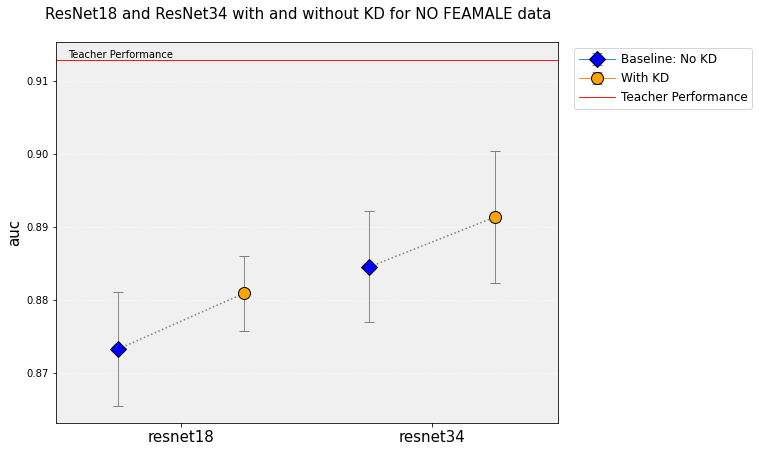

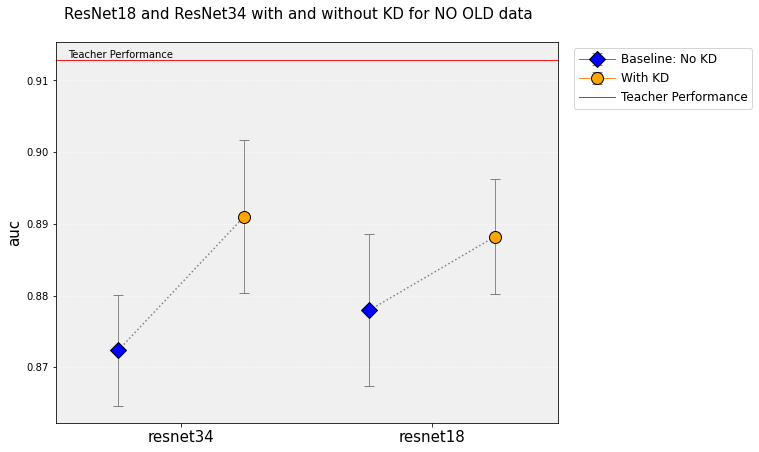

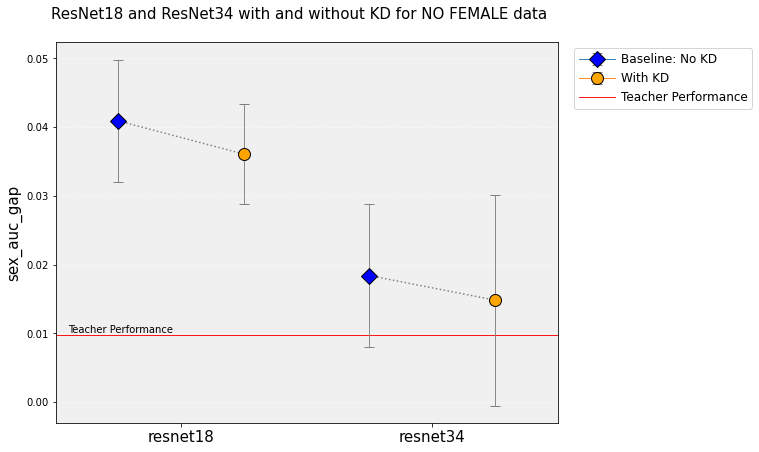

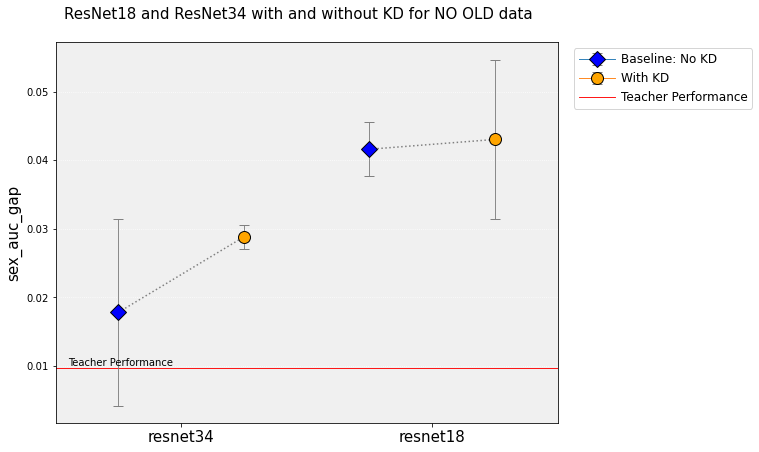

In [6]:
kd_overall_model_performance(
    no_female_df,
    kd_no_female_df,
    original_df,
    'r101-sam1-s42',
    'auc',
    title='ResNet18 and ResNet34 with and without KD for NO FEAMALE data',
)

kd_overall_model_performance(
    no_old_df,
    kd_no_old_df,
    original_df,
    'r101-sam1-s42',
    'auc',
    title='ResNet18 and ResNet34 with and without KD for NO OLD data',
)

kd_overall_model_performance(
    no_female_df,
    kd_no_female_df,
    original_df,
    'r101-sam1-s42',
    'sex_auc_gap',
    title='ResNet18 and ResNet34 with and without KD for NO FEMALE data',
)

kd_overall_model_performance(
    no_old_df,
    kd_no_old_df,
    original_df,
    'r101-sam1-s42',
    'sex_auc_gap',
    title='ResNet18 and ResNet34 with and without KD for NO OLD data',
)

In [8]:
experiment_colors = {
    "sex_no_kd": "violet",
    "age_no_kd": "gold",
    "sex_kd": "darkviolet",
    "age_kd": "orange",
}


def kd_overall_model_subgroup_performance(
        resnet_df: pd.DataFrame,
        kd_df: pd.DataFrame,
        teacher_df: pd.DataFrame,
        subgroups: list[str],
        teacher_id: str,
        metric: str,
        title: str = '',
        bar_width=0.5, 
        line_length=0.05,
    ):

    age_metric = 'age_' + metric
    sex_metric = 'sex_' + metric

    # Get teachers from resnet_df
    age_teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][age_metric][0]
    sex_teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][sex_metric][0]
                            
    # Set up graphical variables
    total_bars = 2 # TODO: Change maybe
    bar_group_width = bar_width * total_bars
    legend_handles = []
    legend_labels = []

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create the plot
    for i, model in enumerate(kd_df['model_name'].unique()):
        for j, subgroup in enumerate(subgroups):
            model_scores = []
            subgroup_metric = subgroup + "_" + metric

            # Get without KD
            scores = resnet_df[(resnet_df['model_name'] == model)][subgroup_metric]
            mean_score = scores.mean()
            std_error = scores.std()
            model_scores.append(mean_score)
            x_pos_no_kd = i - bar_group_width/2 + (0 + 0.5) * bar_width
            handle_no_kd = ax.errorbar(x_pos_no_kd, mean_score, yerr=std_error, marker='D', capsize=5, markersize=12, markerfacecolor=experiment_colors[f'{subgroup}_no_kd'], markeredgecolor='black', ecolor='gray', linewidth=0.9)


            if f'{subgroup.capitalize()} no KD' not in legend_labels:
                legend_handles.append(handle_no_kd)
                legend_labels.append(f'{subgroup.capitalize()} no KD')

            # Get with KD
            scores = kd_df[(kd_df['model_name'] == model)][subgroup_metric]
            mean_score = scores.mean()
            std_error = scores.std()
            model_scores.append(mean_score)
            x_pos_kd = i - bar_group_width/2 + (1 + 0.5) * bar_width
            handle_kd = ax.errorbar(x_pos_kd, mean_score, yerr=std_error, marker='o', capsize=5, markersize=12, markerfacecolor=experiment_colors[f'{subgroup}_kd'], markeredgecolor='black', ecolor='gray', linewidth=0.9)

            
            if f'{subgroup.capitalize()} with KD' not in legend_labels:
                legend_handles.append(handle_kd)
                legend_labels.append(f'{subgroup.capitalize()} with KD')

            # Draw a dotted line between No KD and KD
            ax.plot([x_pos_no_kd, x_pos_kd], [model_scores[0], model_scores[1]], linestyle=':', color='grey')


    # Show Teacher performance:
    teacher_age = ax.axhline(y=age_teacher_performance, linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='red')
    legend_handles.append(teacher_age)
    legend_labels.append('Age Teacher')
    teacher_sex = ax.axhline(y=sex_teacher_performance, linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='pink')
    legend_handles.append(teacher_sex)
    legend_labels.append('Sex Teacher')

    # Add text above the teacher performance line
    ax.text(-0.45, age_teacher_performance, 'Age Teacher Performance', color='black', va='bottom')
    ax.text(-0.45, sex_teacher_performance, 'Sex Teacher Performance', color='black', va='bottom')

    # Customize the plot
    ax.set_xticks(np.arange(len(kd_df['model_name'].unique())))
    ax.set_xticklabels(kd_df['model_name'].unique(), fontsize=15)
    ax.set_ylabel(metric, fontsize=15) 
    # Set the x-axis limits to show all the error bars
    ax.set_xlim(-bar_group_width/2, len(kd_df['model_name'].unique())-1+bar_group_width/2)
    ax.set_facecolor('#F0F0F0')
    # Legend
    ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', handlelength=3.0, handletextpad=0.5, prop={'size': 12})
    # Grid
    ax.yaxis.grid(True, linestyle='dotted', linewidth=0.8, color='white', alpha=1)
    # Title
    fig.suptitle(title, fontsize=15, y=0.95)

    # plt.show()

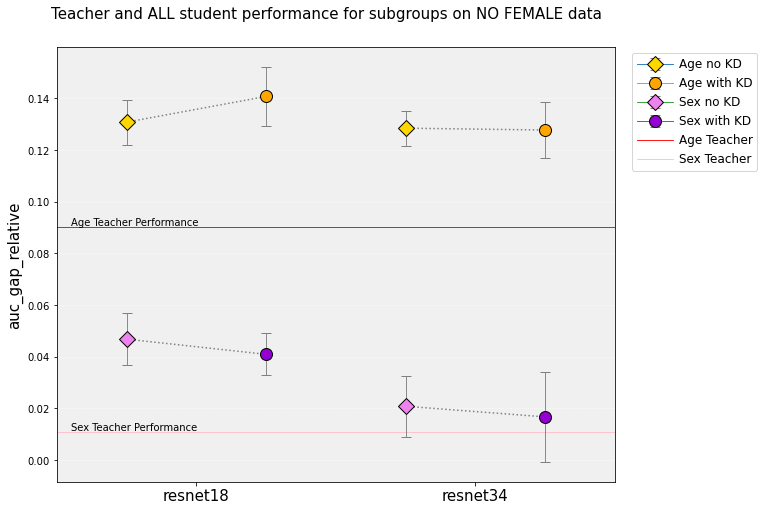

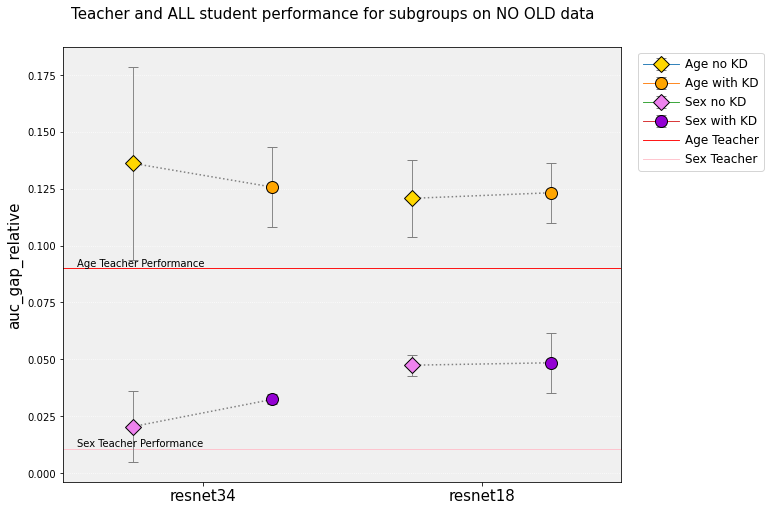

In [9]:
kd_overall_model_subgroup_performance(
    no_female_df,
    kd_no_female_df,
    original_df,
    ['age', 'sex'],
    'r101-sam1-s42',
    'auc_gap_relative',
    title='Teacher and ALL student performance for subgroups on NO FEMALE data'
)

kd_overall_model_subgroup_performance(
    no_old_df,
    kd_no_old_df,
    original_df,
    ['age', 'sex'],
    'r101-sam1-s42',
    'auc_gap_relative',
    title='Teacher and ALL student performance for subgroups on NO OLD data'
)

In [10]:
from typing import List
metric_names = {
    'auc': 'AUC',
    'age_auc_group_0': 'Age < 60 AUC',
    'age_auc_group_1': 'Age 60+ AUC',
    'sex_auc_group_0': 'Male AUC',
    'sex_auc_group_1': 'Female AUC',
    'avg_auc_gap': 'Avg AUC Gap',
    'age_auc_gap': 'Age AUC Gap',
    'sex_auc_gap': 'Sex AUC Gap',
    'age_eq_odds': 'Age Eq. Odds',
    'sex_eq_odds': 'Sex Eq. Odds',
}

def overall_radar_plot(
    resnet_df: pd.DataFrame, # baseline
    kd_df: pd.DataFrame,    # kd results
    original_df: pd.DataFrame, # df to take the teacher performance from
    metrics: List[str],
    teacher_id: str,
    student_model: str, # resnet18 or resnet34
    title: str = 'title',
    is_performance: bool = True,
):
    # get the teacher performance
    teacher_df = original_df[original_df['model_id'] == teacher_id]
    teacher_df = teacher_df[metrics]
    teacher_df = teacher_df.rename(columns=metric_names)
    teacher_df = teacher_df.melt(var_name='metric', value_name='value')

    # get the average baseline performance by model
    student_baseline = resnet_df[resnet_df['model_name'] == student_model]
    student_baseline = student_baseline[metrics]
    student_baseline = student_baseline.rename(columns=metric_names)
    student_baseline = student_baseline.mean().to_frame().T
    student_baseline = student_baseline.melt(var_name='metric', value_name='value')
    
    # get the average kd performance by model
    student_kd = kd_df[(kd_df['model_name'] == student_model) & (kd_df['teacher_id'] == teacher_id)]
    student_kd = student_kd[metrics]
    student_kd = student_kd.rename(columns=metric_names)
    student_kd = student_kd.mean().to_frame().T
    student_kd = student_kd.melt(var_name='metric', value_name='value')

    # Add last element to create a circular effect
    teacher_df = teacher_df.append(teacher_df.iloc[0], ignore_index=True) 
    student_baseline = student_baseline.append(student_baseline.iloc[0], ignore_index=True) 
    student_kd = student_kd.append(student_kd.iloc[0], ignore_index=True) 

    fig = go.Figure()
    fig = px.line_polar(start_angle=90)

    # PERFORMANCE
    if is_performance:
        fig.add_trace(go.Scatterpolar(
            r=teacher_df['value'],
            theta=teacher_df['metric'],
            name='Teacher',
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_kd['value'],
            theta=student_kd['metric'],
            name=f'{student_model.capitalize()} w/ KD',
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_baseline['value'],
            theta=student_baseline['metric'],
            name=f'{student_model.capitalize()} w/o KD',
        ))
        fig.update_layout(
        width=800,  # Set the width of the plot (in pixels)
        height=600,  # Set the height of the plot (in pixels)
        title={
            'text': title,
            'x': 0.5,  # Align the title in the center
            'y': 1.0,  # Adjust the vertical position of the title
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 14}  # Adjust the font size of the title
        },
        polar=dict(
            radialaxis=dict(
            visible=True,
            range=[0.7, 1.0],
            tickvals=list(np.arange(0.75, 1.0, 0.05)),  # Specify the position where ticks appear
            ),
        ),
            showlegend=True,
        )

    # FAIRNESS
    else:
        fig.add_trace(go.Scatterpolar(
            r=student_baseline['value'],
            theta=student_baseline['metric'],
            name=f'{student_model.capitalize()} w/o KD',
            line_color='#AB63FA'
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_kd['value'],
            theta=student_kd['metric'],
            name=f'{student_model.capitalize()} w/ KD',
            line_color='#00CC96'
        ))
        fig.add_trace(go.Scatterpolar(
            r=teacher_df['value'],
            theta=teacher_df['metric'],
            name='Teacher',
            line_color='#EF553B'
        ))
        fig.update_layout(
        width=800,  # Set the width of the plot (in pixels)
        height=600,  # Set the height of the plot (in pixels)
        title={
            'text': title,
            'x': 0.5,  # Align the title in the center
            'y': 1.0,  # Adjust the vertical position of the title
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 14}  # Adjust the font size of the title
        },
        polar=dict(
            radialaxis=dict(
            visible=True,
            # range=[0.0, 0.15],
            # tickvals=list(np.arange(0.75, 1.0, 0.05)),  # Specify the position where ticks appear
            ),
        ),
            showlegend=True,
        )

    fig.update_traces(fill='toself')
    fig.show()


In [11]:
#### NO FEMALE DATASET #####
# OVERALL + SUBGROUP PERFORMANCE
overall_radar_plot(
    no_female_df,
    kd_no_female_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    'r101-sam1-s42',
    student_model='resnet18',
    title='Mean ResNet18 metrics with and without KD comapred to ResNet34 teacher for NO FEMALE dataset'
)

overall_radar_plot(
    no_female_df,
    kd_no_female_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    'r101-sam1-s42',
    student_model='resnet34',
    title='Mean ResNet34 metrics with and without KD comapred to ResNet34 teacher for NO FEMALE dataset'
)

# OVERALL + SUBGROUP FAIRNESS
overall_radar_plot(
    no_female_df,
    kd_no_female_df,
    original_df,
    ['avg_auc_gap', 'age_auc_gap', 'age_eq_odds', 'sex_eq_odds', 'sex_auc_gap'],
    'r101-sam1-s42',
    student_model='resnet18',
    title='Mean ResNet18 metrics with and without KD comapred to ResNet34 teacher for NO FEMALE dataset',
    is_performance=False
)

overall_radar_plot(
    no_female_df,
    kd_no_female_df,
    original_df,
    ['avg_auc_gap', 'age_auc_gap', 'age_eq_odds', 'sex_eq_odds', 'sex_auc_gap'],
    'r101-sam1-s42',
    student_model='resnet34',
    title='Mean ResNet34 metrics with and without KD comapred to ResNet34 teacher for NO FEMALE dataset',
    is_performance=False
)


/tmp/ipykernel_3370501/4089322231.py:46: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3370501/4089322231.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3370501/4089322231.py:48: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_3370501/4089322231.py:46: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3370501/4089322231.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3370501/4089322231.py:48: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_3370501/4089322231.py:46: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3370501/4089322231.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3370501/4089322231.py:48: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_3370501/4089322231.py:46: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3370501/4089322231.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3370501/4089322231.py:48: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [12]:
#### NO OLD DATASET #####
# OVERALL + SUBGROUP PERFORMANCE
overall_radar_plot(
    no_old_df,
    kd_no_old_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    'r101-sam1-s42',
    student_model='resnet18',
    title='Mean ResNet18 metrics with and without KD comapred to ResNet34 teacher for NO OLD dataset'
)

overall_radar_plot(
    no_old_df,
    kd_no_old_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    'r101-sam1-s42',
    student_model='resnet34',
    title='Mean ResNet34 metrics with and without KD comapred to ResNet34 teacher for NO OLD dataset'
)

# OVERALL + SUBGROUP FAIRNESS
overall_radar_plot(
    no_old_df,
    kd_no_old_df,
    original_df,
    ['avg_auc_gap', 'age_auc_gap', 'age_eq_odds', 'sex_eq_odds', 'sex_auc_gap'],
    'r101-sam1-s42',
    student_model='resnet18',
    title='Mean ResNet18 metrics with and without KD comapred to ResNet34 teacher for NO OLD dataset',
    is_performance=False
)

overall_radar_plot(
    no_old_df,
    kd_no_old_df,
    original_df,
    ['avg_auc_gap', 'age_auc_gap', 'age_eq_odds', 'sex_eq_odds', 'sex_auc_gap'],
    'r101-sam1-s42',
    student_model='resnet34',
    title='Mean ResNet34 metrics with and without KD comapred to ResNet34 teacher for NO OLD dataset',
    is_performance=False
)


/tmp/ipykernel_3370501/4089322231.py:46: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3370501/4089322231.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3370501/4089322231.py:48: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_3370501/4089322231.py:46: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3370501/4089322231.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3370501/4089322231.py:48: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_3370501/4089322231.py:46: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3370501/4089322231.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3370501/4089322231.py:48: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_3370501/4089322231.py:46: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3370501/4089322231.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_3370501/4089322231.py:48: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [14]:
student_ids = {
    'No Female': ['r18-sam1-s43', 'r18-sam1-s46', 'r34-sam1-s42', 'r34-sam1-s43'],
    'No Old': ['r18-sam1-s43', 'r18-sam1-s46', 'r34-sam1-s42', 'r34-sam1-s43'],
}

student_seeds = {
    'No Female':
    {
        'resnet18': [43, 46],
        'resnet34': [42, 43]
    },
    'No Old':
    {
        'resnet18': [43, 46],
        'resnet34': [42, 43]
    }
}

def plot_relative_subgroup_performance(
    resnet_df: pd.DataFrame,
    kd_df: pd.DataFrame,
    original_df: pd.DataFrame,
    teacher_id: str,
    metric: str = 'auc',
    title: str = '',
    experiment: str = 'No Female',
    unfair_seeds: bool = True,
):

    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")

    subgroup_metrics = [f'age_{metric}_group_0', f'age_{metric}_group_1', f'sex_{metric}_group_0', f'sex_{metric}_group_1']
    subgroup_metrics_names = {
        f'age_{metric}_group_0_relative_change': 'Age < 60',
        f'age_{metric}_group_1_relative_change': 'Age 60+',
        f'sex_{metric}_group_0_relative_change': 'Male',
        f'sex_{metric}_group_1_relative_change': 'Female',
    }

    # Filter the df to only include the models we want
    kd_df = kd_df[kd_df['teacher_id'] == teacher_id]
    teacher_df = original_df[original_df['model_id'] == teacher_id]

    if unfair_seeds:
        resnet_df = resnet_df[resnet_df['model_id'].isin(student_ids[experiment])]
    else:
        resnet_df = resnet_df[resnet_df['model_name'].isin(['resnet18', 'resnet34'])]


    # Calculate average metric
    avg_metric = 'avg_'+metric
    kd_df[avg_metric] = kd_df[subgroup_metrics].mean(axis=1)
    teacher_df[avg_metric] = teacher_df[subgroup_metrics].mean(axis=1)
    resnet_df[avg_metric] = resnet_df[subgroup_metrics].mean(axis=1)

    kd_df = kd_df[['model_name', 'seed', avg_metric] + subgroup_metrics]
    teacher_df = teacher_df[['model_name', 'seed', avg_metric] + subgroup_metrics]
    resnet_df = resnet_df[['model_name', 'seed', avg_metric] + subgroup_metrics]

    teacher_df['model_name'] = 'Teacher'
    resnet_df['model_name'] = resnet_df['model_name'].map({'resnet18': 'resnet18 w/o KD', 'resnet34': 'resnet34 w/o KD'})
    kd_df = pd.concat([kd_df, teacher_df, resnet_df])
    
    # Calculate relative change
    for column in subgroup_metrics:
        kd_df[column + '_relative_change'] = (kd_df[column] - kd_df[avg_metric]) / kd_df[avg_metric] * 100

    kd_df = kd_df.drop(columns=subgroup_metrics + [avg_metric])

    teacher_df = kd_df[kd_df['model_name'] == 'Teacher']
    res18_no_kd_df = kd_df[kd_df['model_name'] == 'resnet18 w/o KD']
    res34_no_kd_df = kd_df[kd_df['model_name'] == 'resnet34 w/o KD']

    if unfair_seeds:
        res18_df = kd_df[kd_df['seed'].isin(student_seeds[experiment]['resnet18']) & (kd_df['model_name'] == 'resnet18')]
        res34_df = kd_df[kd_df['seed'].isin(student_seeds[experiment]['resnet34']) & (kd_df['model_name'] == 'resnet34')]
    else:
        res18_df = kd_df[kd_df['model_name'] == 'resnet18']
        res34_df = kd_df[kd_df['model_name'] == 'resnet34']
    

    kd_df = pd.concat([teacher_df, res18_df, res34_df, res18_no_kd_df, res34_no_kd_df])
    kd_df = kd_df.drop(columns=['seed'])
    kd_df['model_name'] = kd_df['model_name'].map({'resnet18': 'resnet18 w/ KD', 'resnet34': 'resnet34 w/ KD'}).fillna(kd_df['model_name'])
    kd_df = kd_df.melt('model_name', var_name='metric', value_name='value')

    g = sns.catplot(
        data=kd_df, kind="bar", x='metric', y='value', hue="model_name", height=5, aspect=1.6, width=0.5,
    )
    g._legend.remove()
    g.ax.set_axisbelow(True)

    # # # Set the custom y-scale
    # min_val = df['value'].min()
    # max_val = df['value'].max()
    # plt.ylim(min_val - 0.1 * abs(min_val), max_val + 0.1 * abs(max_val))

    # Add horizontal grid lines and make them dotted
    g.ax.yaxis.grid(True, linestyle='dotted')
    
    # Add border
    g.ax.spines['top'].set_visible(True)
    g.ax.spines['right'].set_visible(True)

    legend = plt.legend(title='Models', handlelength=2, labelspacing=1.2)

    x_labels = [subgroup_metrics_names.get(metric, metric) for metric in kd_df['metric'].unique()]
    g.ax.set_xticklabels(x_labels)

    # Set titles
    plt.xlabel('')
    plt.ylabel(f'Difference in % from average\n {metric}') 
    plt.title(title)

    # # Move the legend outside and adjust its position
    legend.set_bbox_to_anchor((1.1, 0.9))  # Adjust the coordinates for desired positioning

    plt.rcParams['figure.dpi'] = 120
    plt.show()


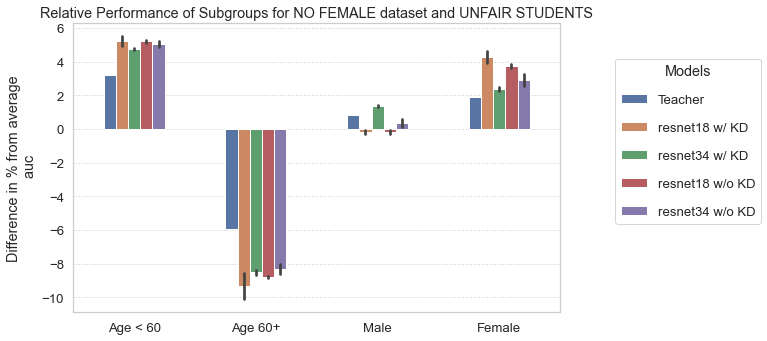

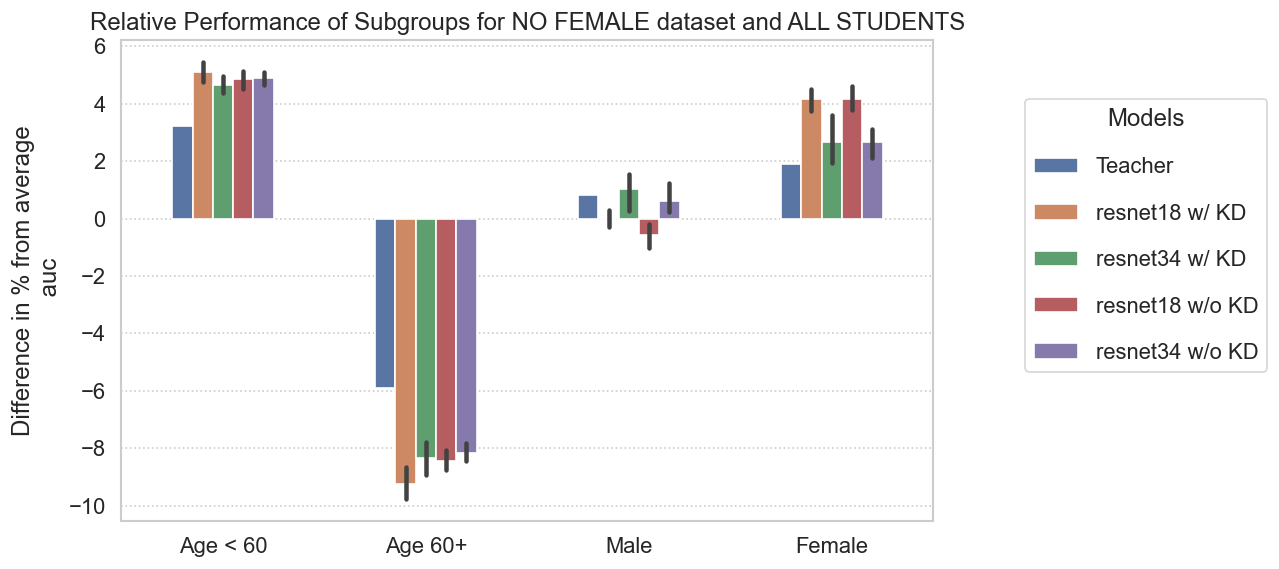

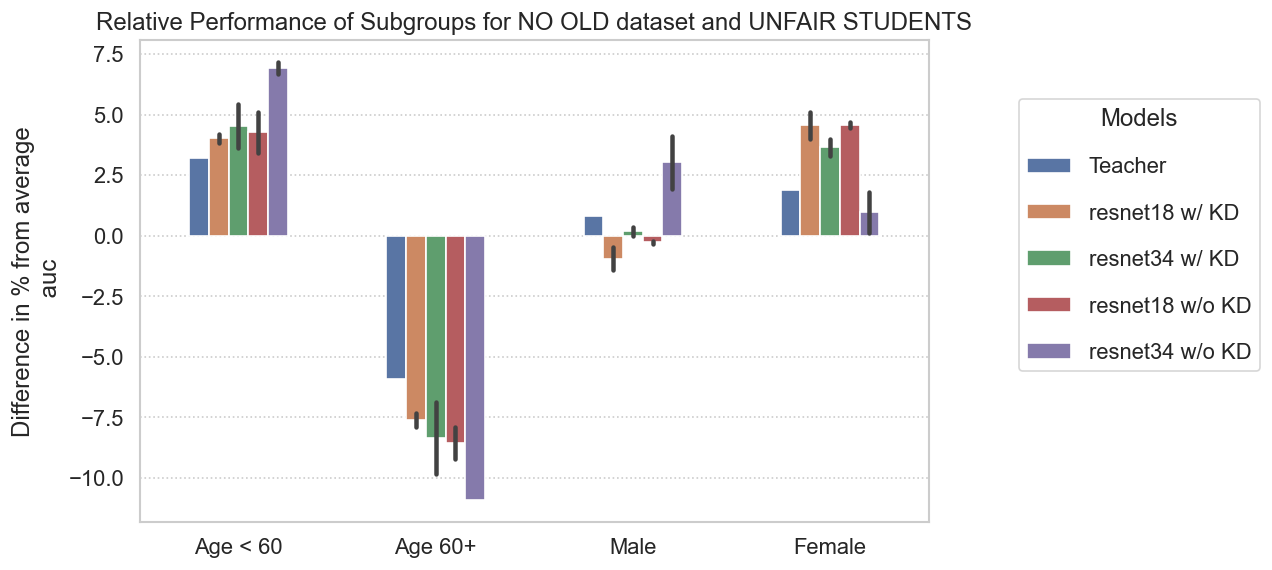

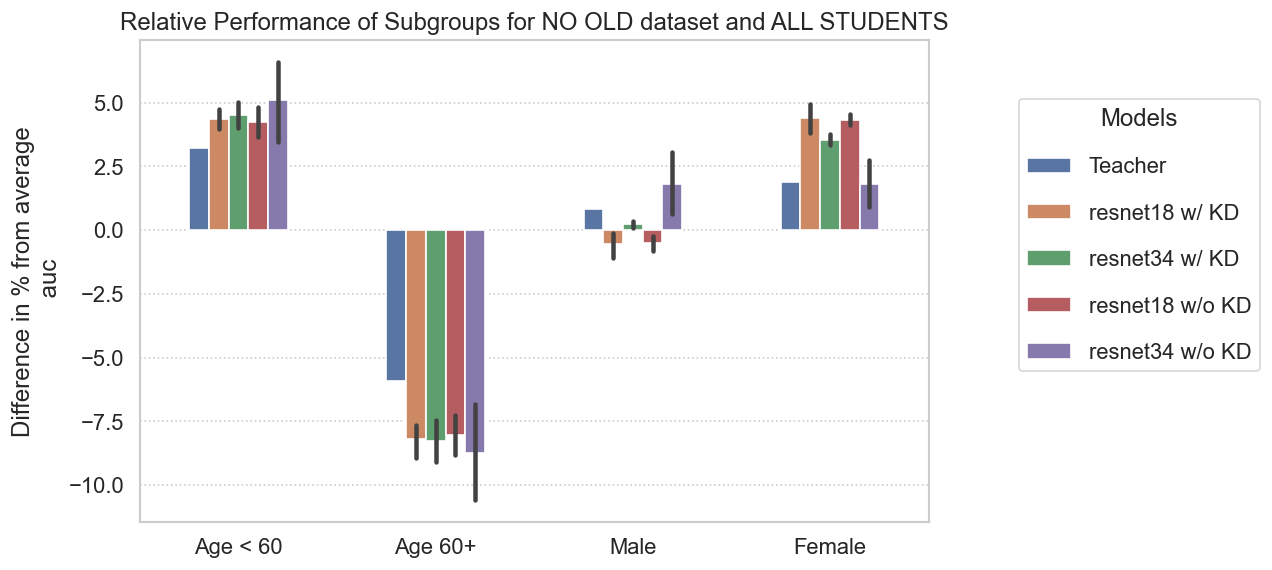

In [15]:
plot_relative_subgroup_performance(
    no_female_df,
    kd_no_female_df,
    original_df,
    'r101-sam1-s42',
    metric='auc',
    title='Relative Performance of Subgroups for NO FEMALE dataset and UNFAIR STUDENTS',
    unfair_seeds = True,
)

plot_relative_subgroup_performance(
    no_female_df,
    kd_no_female_df,
    original_df,
    'r101-sam1-s42',
    metric='auc',
    title='Relative Performance of Subgroups for NO FEMALE dataset and ALL STUDENTS',
    unfair_seeds = False,
)

plot_relative_subgroup_performance(
    no_old_df,
    kd_no_old_df,
    original_df,
    'r101-sam1-s42',
    metric='auc',
    title='Relative Performance of Subgroups for NO OLD dataset and UNFAIR STUDENTS',
    unfair_seeds = True,
)

plot_relative_subgroup_performance(
    no_old_df,
    kd_no_old_df,
    original_df,
    'r101-sam1-s42',
    metric='auc',
    title='Relative Performance of Subgroups for NO OLD dataset and ALL STUDENTS',
    unfair_seeds = False,
)

### Individual Analysis (for specific student seeds)

#### Tables

In [43]:

student_ids = {
    'No Female': ['r18-sam1-s43', 'r18-sam1-s46', 'r34-sam1-s42', 'r34-sam1-s43'],
    'No Old': ['r18-sam1-s43', 'r18-sam1-s46', 'r34-sam1-s42', 'r34-sam1-s43'],
}

student_seeds = {
    'No Female':
    {
        'resnet18': [43, 46],
        'resnet34': [42, 43]
    },
    'No Old':
    {
        'resnet18': [43, 46],
        'resnet34': [42, 43]
    }
}

def detailed_kd_table(
    resnet_df: pd.DataFrame, # baseline
    kd_df: pd.DataFrame,    # kd results
    original_df: pd.DataFrame, # df to take the teacher performance from
    kd_experiment: str, # experiment name (No Female or No Old)
    teacher_id: str, # teacher id
    # metrics: list[str] = ['model_id', 'auc', 'auc_gap', 'auc_gap_relative', 'age_auc_gap', 'sex_auc_gap', 'avg_auc_gap_relative'],
    metrics: list[str] = ['auc', 'auc_gap', 'auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative', 'avg_auc_gap_relative'],
    avg_per_seed: bool = True,
):
    def calculate_similarity(row, teacher_row):
        return np.linalg.norm(teacher_row.to_numpy() - row.to_numpy())
        # return distance.euclidean(row, teacher_row)

    if avg_per_seed:
        metrics = metrics + ['model_id']
        index = 'model_id'
    else:
        metrics = metrics + ['model_id', 'model_name']
        index = ['model_id', 'model_name']

    teacher_df = original_df[original_df['model_id'] == teacher_id]
    teacher_df = teacher_df[metrics]
    teacher_df.set_index(index, inplace=True)

    # get the average baseline performance by model
    resnet_df = resnet_df[resnet_df['model_id'].isin(student_ids[kd_experiment])]
    resnet_df = resnet_df[metrics]
    resnet_df.set_index(index, inplace=True)
    resnet_df.sort_index(inplace=True)
    
    # Add euclidean similarity between teacher and student
    resnet_df['sim'] = resnet_df.apply(lambda row: calculate_similarity(row, teacher_df.iloc[0]), axis=1)

    # get the average kd performance by model
    kd_df['model_id'] = kd_df['model_id'].str.split("_").map(lambda x: x[0])

    if 'kd1' in kd_df['model_id'].iloc[0]:
        kd_df['model_id'] = kd_df['model_id'].replace('kd1-', '', regex=True)
    else:
        kd_df['model_id'] = kd_df['model_id'].replace('kd2-fm0101-', '', regex=True)

    kd_df = kd_df[kd_df['model_id'].isin(student_ids[kd_experiment])]
    kd_df = kd_df[metrics]
    kd_df.set_index(index, inplace=True)
    kd_df.sort_index(inplace=True)

    # Add euclidean similarity between teacher and student
    kd_df['sim'] = kd_df.apply(lambda row: calculate_similarity(row, teacher_df.iloc[0]), axis=1)

    # get the relative change in performance compared to the baseline
    kd_relative_df = ((kd_df - resnet_df) / resnet_df)

    teacher_df['Data'] = 'Teacher'
    resnet_df['Data'] = 'Baseline'
    kd_df['Data'] = 'KD'
    kd_relative_df['Data'] = 'Relative Change'
    df = pd.concat([teacher_df, resnet_df, kd_df, kd_relative_df])

    if not avg_per_seed:
        # Average
        df = df.groupby(['model_name', 'Data']).mean()
    display(df)


In [45]:
print("No Female")
detailed_kd_table(
    no_female_df,
    kd_no_female_df,
    original_df,
    'No Female',
    'r101-sam1-s42',
)

print("No Old")
detailed_kd_table(
    no_old_df,
    kd_no_old_df,
    original_df,
    'No Old',
    'r101-sam1-s42',
)

print('HIGH CAPACITY TEACHER: r101-sam1-s42')
print("No Female")
detailed_kd_table(
    no_female_df,
    kd_no_female_df,
    original_df,
    'No Female',
    'r101-sam1-s42',
    metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    avg_per_seed=False
)
detailed_kd_table(
    no_female_df,
    kd_no_female_df,
    original_df,
    'No Female',
    'r101-sam1-s42',
    metrics=['auc', 'avg_auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative'],
    avg_per_seed=False
)


print('FEATURE KD')
# detailed_kd_table(
#     no_female_df,
#     feature_no_female_df,
#     original_df,
#     'No Female',
#     'r101-sam1-s42',
#     metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
#     avg_per_seed=False
# )
print("No Female")
detailed_kd_table(
    no_female_df,
    feature_no_female_df,
    original_df,
    'No Female',
    'r101-sam1-s42',
    metrics=['auc', 'avg_auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative'],
    avg_per_seed=False
)

# print("No Old")
# detailed_kd_table(
#     no_old_df,
#     kd_no_old_df,
#     original_df,
#     'No Old',
#     'r101-sam1-s42',
#     metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
#     avg_per_seed=False
# )
# detailed_kd_table(
#     no_old_df,
#     kd_no_old_df,
#     original_df,
#     'No Old',
#     'r101-sam1-s42',
#     metrics=['auc', 'avg_auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative'],
#     avg_per_seed=False
# )

# print('FEATURE KD')
# detailed_kd_table(
#     no_old_df,
#     feature_no_old_df,
#     original_df,
#     'No Old',
#     'r101-sam1-s42',
#     metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
#     avg_per_seed=False
# )
print("No Old")
detailed_kd_table(
    no_old_df,
    feature_no_old_df,
    original_df,
    'No Old',
    'r101-sam1-s42',
    metrics=['auc', 'avg_auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative'],
    avg_per_seed=False
)


# print('ORIGINAL TEACHER: r34-sam1-s46')
# original_kd_no_female_df = read_data('../../results/ham10000_no_female/kd/', 'r34-sam1-s46')
# original_kd_no_old_df = read_data('../../results/ham10000_no_old/kd/', 'r34-sam1-s46')
# print("No Female")
# detailed_kd_table(
#     no_female_df,
#     original_kd_no_female_df,
#     original_df,
#     'No Female',
#     'r34-sam1-s46',
#     metrics=['auc', 'avg_auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative'],
#     avg_per_seed=False
# )


# print("No Old")
# detailed_kd_table(
#     no_old_df,
#     original_kd_no_old_df,
#     original_df,
#     'No Old',
#     'r34-sam1-s46',
#     metrics=['auc', 'avg_auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative'],
#     avg_per_seed=False
# )

No Female


auc   auc_gap  auc_gap_relative  age_auc_gap_relative  \
model_id                                                                    
r101-sam1-s42  0.912908  0.082212          0.090055              0.090055   
r18-sam1-s43   0.871673  0.118844          0.136340              0.136340   
r18-sam1-s46   0.865149  0.120317          0.139071              0.139071   
r34-sam1-s42   0.873930  0.119040          0.136212              0.136212   
r34-sam1-s43   0.880714  0.111982          0.127150              0.127150   
r18-sam1-s43   0.878568  0.134300          0.152862              0.152862   
r18-sam1-s46   0.885676  0.117734          0.132931              0.132931   
r34-sam1-s42   0.895652  0.114874          0.128258              0.128258   
r34-sam1-s43   0.886508  0.117687          0.132753              0.132753   
r18-sam1-s43   0.007910  0.130048          0.121180              0.121180   
r18-sam1-s46   0.023727 -0.021471         -0.044150             -0.044150   
r34-sam1-s42   0.024855 -0.034995         -0.058398             -0.058398   
r34-sam1-s43   0.006580  0.050943          0.044073              0.044073   

               sex_auc_gap_relative  avg_auc_gap_relative             Data  \
model_id                                                                     
r101-sam1-s42              0.010703              0.050379          Teacher   
r18-sam1-s43               0.040787              0.088564         Baseline   
r18-sam1-s46               0.036336              0.087704         Baseline   
r34-sam1-s42               0.031175              0.083694         Baseline   
r34-sam1-s43               0.019163              0.073156         Baseline   
r18-sam1-s43               0.045738              0.099300               KD   
r18-sam1-s46               0.041813              0.087372               KD   
r34-sam1-s42               0.008602              0.068430               KD   
r34-sam1-s43               0.012067              0.072410               KD   
r18-sam1-s43               0.121375              0.121225  Relative Change   
r18-sam1-s46               0.150717             -0.003783  Relative Change   
r34-sam1-s42              -0.724089             -0.182380  Relative Change   
r34-sam1-s43              -0.370269             -0.010194  Relative Change   

                    sim  
model_id                 
r101-sam1-s42       NaN  
r18-sam1-s43   0.098437  
r18-sam1-s46   0.102899  
r34-sam1-s42   0.093089  
r34-sam1-s43   0.072561  
r18-sam1-s43   0.124106  
r18-sam1-s46   0.089534  
r34-sam1-s42   0.067924  
r34-sam1-s43   0.078031  
r18-sam1-s43   0.260764  
r18-sam1-s46  -0.129886  
r34-sam1-s42  -0.270328  
r34-sam1-s43   0.075392

No Old


auc   auc_gap  auc_gap_relative  age_auc_gap_relative  \
model_id                                                                    
r101-sam1-s42  0.912908  0.082212          0.090055              0.090055   
r18-sam1-s43   0.880396  0.124011          0.140859              0.140859   
r18-sam1-s46   0.859375  0.105867          0.123191              0.110785   
r34-sam1-s42   0.875396  0.150687          0.172135              0.172135   
r34-sam1-s43   0.871006  0.154614          0.177512              0.177512   
r18-sam1-s43   0.897332  0.100002          0.111444              0.109891   
r18-sam1-s46   0.893073  0.114506          0.128216              0.119324   
r34-sam1-s42   0.897110  0.092887          0.103540              0.103540   
r34-sam1-s43   0.872629  0.130592          0.149654              0.149654   
r18-sam1-s43   0.019236 -0.193605         -0.208825             -0.219852   
r18-sam1-s46   0.039212  0.081604          0.040792              0.077083   
r34-sam1-s42   0.024804 -0.383575         -0.398494             -0.398494   
r34-sam1-s43   0.001863 -0.155367         -0.156938             -0.156938   

               sex_auc_gap_relative  avg_auc_gap_relative             Data  \
model_id                                                                     
r101-sam1-s42              0.010703              0.050379          Teacher   
r18-sam1-s43               0.046936              0.093897         Baseline   
r18-sam1-s46               0.047944              0.079364         Baseline   
r34-sam1-s42               0.039115              0.105625         Baseline   
r34-sam1-s43               0.001379              0.089445         Baseline   
r18-sam1-s43               0.043853              0.076872               KD   
r18-sam1-s46               0.064475              0.091900               KD   
r34-sam1-s42               0.032587              0.068064               KD   
r34-sam1-s43               0.035574              0.092614               KD   
r18-sam1-s43              -0.065681             -0.181319  Relative Change   
r18-sam1-s46               0.344807              0.157949  Relative Change   
r34-sam1-s42              -0.166887             -0.355610  Relative Change   
r34-sam1-s43              24.804575              0.035427  Relative Change   

                    sim  
model_id                 
r101-sam1-s42       NaN  
r18-sam1-s43   0.105701  
r18-sam1-s46   0.084735  
r34-sam1-s42   0.153067  
r34-sam1-s43   0.154623  
r18-sam1-s43   0.056664  
r18-sam1-s46   0.091458  
r34-sam1-s42   0.038973  
r34-sam1-s43   0.116057  
r18-sam1-s43  -0.463926  
r18-sam1-s46   0.079343  
r34-sam1-s42  -0.745386  
r34-sam1-s43  -0.249417

HIGH CAPACITY TEACHER: r101-sam1-s42
No Female


auc  age_auc_group_0  age_auc_group_1  \
model_name Data                                                          
resnet101  Teacher          0.912908         0.930059         0.847847   
resnet18   Baseline         0.868411         0.899070         0.779489   
           KD               0.882122         0.911059         0.785042   
           Relative Change  0.015818         0.013362         0.007229   
resnet34   Baseline         0.877322         0.907460         0.791949   
           KD               0.891080         0.917709         0.801429   
           Relative Change  0.015717         0.011316         0.012085   

                            sex_auc_group_0  sex_auc_group_1       sim  
model_name Data                                                         
resnet101  Teacher                 0.908446         0.918217       NaN  
resnet18   Baseline                0.853175         0.886670  0.108043  
           KD                      0.864333         0.902941  0.086285  
           Relative Change         0.013106         0.018400 -0.188376  
resnet34   Baseline                0.866925         0.888986  0.086534  
           KD                      0.887890         0.897091  0.060533  
           Relative Change         0.024276         0.009123 -0.280202

auc  avg_auc_gap_relative  \
model_name Data                                              
resnet101  Teacher          0.912908              0.050379   
resnet18   Baseline         0.868411              0.088134   
           KD               0.882122              0.093336   
           Relative Change  0.015818              0.058721   
resnet34   Baseline         0.877322              0.078425   
           KD               0.891080              0.070420   
           Relative Change  0.015717             -0.096287   

                            age_auc_gap_relative  sex_auc_gap_relative  \
model_name Data                                                          
resnet101  Teacher                      0.090055              0.010703   
resnet18   Baseline                     0.137706              0.038562   
           KD                           0.142897              0.043775   
           Relative Change              0.038515              0.136046   
resnet34   Baseline                     0.131681              0.025169   
           KD                           0.130506              0.010335   
           Relative Change             -0.007163             -0.547179   

                                 sim  
model_name Data                       
resnet101  Teacher               NaN  
resnet18   Baseline         0.080418  
           KD               0.081814  
           Relative Change  0.020758  
resnet34   Baseline         0.063381  
           KD               0.050264  
           Relative Change -0.182183

FEATURE KD
No Female


auc  avg_auc_gap_relative  \
model_name Data                                              
resnet101  Teacher          0.912908              0.050379   
resnet18   Baseline         0.868411              0.088134   
           KD               0.892056              0.092143   
           Relative Change  0.027248              0.044819   
resnet34   Baseline         0.877322              0.078425   
           KD               0.888712              0.069910   
           Relative Change  0.012985             -0.102617   

                            age_auc_gap_relative  sex_auc_gap_relative  \
model_name Data                                                          
resnet101  Teacher                      0.090055              0.010703   
resnet18   Baseline                     0.137706              0.038562   
           KD                           0.140412              0.043874   
           Relative Change              0.021251              0.134866   
resnet34   Baseline                     0.131681              0.025169   
           KD                           0.116890              0.022930   
           Relative Change             -0.112273              0.049227   

                                 sim  
model_name Data                       
resnet101  Teacher               NaN  
resnet18   Baseline         0.080418  
           KD               0.076874  
           Relative Change -0.037886  
resnet34   Baseline         0.063381  
           KD               0.043965  
           Relative Change -0.294865

No Old


auc  avg_auc_gap_relative  \
model_name Data                                              
resnet101  Teacher          0.912908              0.050379   
resnet18   Baseline         0.869886              0.086631   
           KD               0.886220              0.078930   
           Relative Change  0.018928             -0.077013   
resnet34   Baseline         0.873201              0.097535   
           KD               0.893370              0.071902   
           Relative Change  0.023092             -0.260899   

                            age_auc_gap_relative  sex_auc_gap_relative  \
model_name Data                                                          
resnet101  Teacher                      0.090055              0.010703   
resnet18   Baseline                     0.125822              0.047440   
           KD                           0.124854              0.033005   
           Relative Change              0.009842             -0.305959   
resnet34   Baseline                     0.174824              0.020247   
           KD                           0.114411              0.029394   
           Relative Change             -0.345734              6.130251   

                                 sim  
model_name Data                       
resnet101  Teacher               NaN  
resnet18   Baseline         0.078523  
           KD               0.057262  
           Relative Change -0.263340  
resnet34   Baseline         0.107263  
           KD               0.044165  
           Relative Change -0.588596

#### Plots

In [16]:
from typing import List
metric_names = {
    'auc': 'AUC',
    'age_auc_group_0': 'Age < 60 AUC',
    'age_auc_group_1': 'Age 60+ AUC',
    'sex_auc_group_0': 'Male AUC',
    'sex_auc_group_1': 'Female AUC',
    'avg_auc_gap': 'Avg AUC Gap',
    'age_auc_gap': 'Age AUC Gap',
    'sex_auc_gap': 'Sex AUC Gap',
    'age_eq_odds': 'Age Eq. Odds',
    'sex_eq_odds': 'Sex Eq. Odds',
}

student_ids = {
    'No Female': ['r18-sam1-s43', 'r18-sam1-s46', 'r34-sam1-s42', 'r34-sam1-s43'],
    'No Old': ['r18-sam1-s43', 'r18-sam1-s46', 'r34-sam1-s42', 'r34-sam1-s43'],
}

student_seeds = {
    'No Female':
    {
        'resnet18': [43, 46],
        'resnet34': [42, 43]
    },
    'No Old':
    {
        'resnet18': [43, 46],
        'resnet34': [42, 43]
    }
}

def individual_radar_plot(
    resnet_df: pd.DataFrame, # baseline
    kd_df: pd.DataFrame,    # kd results
    original_df: pd.DataFrame, # df to take the teacher performance from
    metrics: List[str],
    teacher_id: str,
    student_model: str, # resnet18 or resnet34
    experiment: str, # No Female or No Old
    title: str = 'title',
    is_performance: bool = True,
):
    # get the teacher performance
    teacher_df = original_df[original_df['model_id'] == teacher_id]
    teacher_df = teacher_df[metrics]
    teacher_df = teacher_df.rename(columns=metric_names)
    teacher_metrics = teacher_df.to_numpy()
    teacher_df = teacher_df.melt(var_name='metric', value_name='value')

    # get the average baseline performance by model
    student_baseline = resnet_df[(resnet_df['model_name'] == student_model) & (resnet_df['seed'].isin(student_seeds[experiment][student_model]))]
    student_baseline = student_baseline[metrics]
    student_baseline = student_baseline.rename(columns=metric_names)
    student_baseline = student_baseline.mean().to_frame().T
    baseline_metrics = student_baseline.to_numpy()
    student_baseline = student_baseline.melt(var_name='metric', value_name='value')

    # get the average kd performance by model
    student_kd = kd_df[(kd_df['model_name'] == student_model) & (kd_df['seed'].isin(student_seeds[experiment][student_model]))]
    student_kd = student_kd[metrics]
    display(student_kd)
    student_kd = student_kd.rename(columns=metric_names)
    student_kd = student_kd.mean().to_frame().T
    kd_metrics = student_kd.to_numpy()
    student_kd = student_kd.melt(var_name='metric', value_name='value')


    # Calculate the Euclidean Distance
    distance_before = np.linalg.norm(teacher_metrics - baseline_metrics)
    distance_after = np.linalg.norm(teacher_metrics - kd_metrics)
    print(f"Distance before: {distance_before}")
    print(f"Distance after: {distance_after}")
    print(f"Distance difference: {(distance_before - distance_after) / distance_before * 100}")

    max_distance = np.sqrt(len(metrics))
    distance = np.linalg.norm(teacher_metrics - kd_metrics)
    # Calculate the similarity as a percentage
    similarity_percentage = (1 - distance / max_distance) * 100
    print(f"Similarity: {similarity_percentage}")

    # Add last element to create a circular effect
    teacher_df = teacher_df.append(teacher_df.iloc[0], ignore_index=True) 
    student_baseline = student_baseline.append(student_baseline.iloc[0], ignore_index=True) 
    student_kd = student_kd.append(student_kd.iloc[0], ignore_index=True) 

    fig = go.Figure()
    fig = px.line_polar(start_angle=90)

    # PERFORMANCE
    if is_performance:
        fig.add_trace(go.Scatterpolar(
            r=teacher_df['value'],
            theta=teacher_df['metric'],
            name='Teacher',
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_kd['value'],
            theta=student_kd['metric'],
            name=f'{student_model.capitalize()} w/ KD',
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_baseline['value'],
            theta=student_baseline['metric'],
            name=f'{student_model.capitalize()} w/o KD',
        ))
        fig.update_layout(
        width=650,  # Set the width of the plot (in pixels)
        height=500,  # Set the height of the plot (in pixels)
        title={
            'text': title,
            'x': 0.5,  # Align the title in the center
            'y': 1.0,  # Adjust the vertical position of the title
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 14}  # Adjust the font size of the title
        },
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0.7, 1.0],
                tickvals=list(np.arange(0.75, 1.0, 0.05)),  # Specify the position where ticks appear
            ),
            angularaxis=dict(
                tickfont=dict(size=14),  # Adjust the font size of the angular labels (metric names)
        ),
        ),
            showlegend=True,
        )

    # FAIRNESS
    else:
        fig.add_trace(go.Scatterpolar(
            r=student_baseline['value'],
            theta=student_baseline['metric'],
            name=f'{student_model.capitalize()} w/o KD',
            line_color='#AB63FA'
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_kd['value'],
            theta=student_kd['metric'],
            name=f'{student_model.capitalize()} w/ KD',
            line_color='#00CC96'
        ))
        fig.add_trace(go.Scatterpolar(
            r=teacher_df['value'],
            theta=teacher_df['metric'],
            name='Teacher',
            line_color='#EF553B'
        ))
        fig.update_layout(
        width=650,  # Set the width of the plot (in pixels)
        height=500,  # Set the height of the plot (in pixels)
        title={
            'text': title,
            'x': 0.5,  # Align the title in the center
            'y': 1.0,  # Adjust the vertical position of the title
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 14}  # Adjust the font size of the title
        },
        polar=dict(
            radialaxis=dict(
                visible=True,
                # range=[0.0, 0.15],
                # tickvals=list(np.arange(0.75, 1.0, 0.05)),  # Specify the position where ticks appear
            ),
                angularaxis=dict(
                tickfont=dict(size=14),  # Adjust the font size of the angular labels (metric names)
            ),
        ),
            showlegend=True,
        )

    fig.update_traces(fill='toself')
    fig.show()


In [77]:
individual_radar_plot(
    no_female_df,
    kd_no_female_df,
    original_df,
    metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    teacher_id='r101-sam1-s42',
    student_model='resnet18',
    title='NO FEMALE data subgroup performance for UNFAIR ResNet18 seeds',
    is_performance=True,
    experiment='No Female'
)

individual_radar_plot(
    no_female_df,
    kd_no_female_df,
    original_df,
    metrics=['avg_auc_gap', 'age_auc_gap', 'age_eq_odds', 'sex_eq_odds', 'sex_auc_gap'],
    teacher_id='r101-sam1-s42',
    student_model='resnet18',
    title='NO FEMALE data subgroup fairness for UNFAIR ResNet18 seeds',
    is_performance=False,
    experiment='No Female'
)

individual_radar_plot(
    no_female_df,
    kd_no_female_df,
    original_df,
    metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    teacher_id='r101-sam1-s42',
    student_model='resnet34',
    title='NO FEMALE data subgroup performance for UNFAIR ResNet34 seeds',
    is_performance=True,
    experiment='No Female'
)

individual_radar_plot(
    no_female_df,
    kd_no_female_df,
    original_df,
    metrics=['avg_auc_gap', 'age_auc_gap', 'age_eq_odds', 'sex_eq_odds', 'sex_auc_gap'],
    teacher_id='r101-sam1-s42',
    student_model='resnet34',
    title='NO FEMALE data subgroup fairness for UNFAIR ResNet34 seeds',
    is_performance=False,
    experiment='No Female'
)

individual_radar_plot(
    no_old_df,
    kd_no_old_df,
    original_df,
    metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    teacher_id='r101-sam1-s42',
    student_model='resnet18',
    title='NO OLD data subgroup performance for UNFAIR ResNet18 seeds',
    is_performance=True,
    experiment='No Old'
)


individual_radar_plot(
    no_old_df,
    kd_no_old_df,
    original_df,
    metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1'],
    teacher_id='r101-sam1-s42',
    student_model='resnet34',
    title='NO OLD data subgroup performance for UNFAIR ResNet34 seeds',
    is_performance=True,
    experiment='No Old'
)

auc  age_auc_group_0  age_auc_group_1  sex_auc_group_0  \
0  0.878568         0.907526         0.773226         0.859914   
0  0.885676         0.914592         0.796858         0.868753   

   sex_auc_group_1  
0         0.900098  
0         0.905785

Distance before: 0.10799574654242132
Distance after: 0.08621216111757826
Distance difference: 20.170780907826167
Similarity: 96.14447494507861


/tmp/ipykernel_199065/954929508.py:83: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_199065/954929508.py:84: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_199065/954929508.py:85: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



avg_auc_gap  age_auc_gap  age_eq_odds  sex_eq_odds  sex_auc_gap
0     0.087242     0.134300     0.186999     0.051588     0.040184
0     0.077383     0.117734     0.177062     0.031646     0.037033

Distance before: 0.12516789406385478
Distance after: 0.12886865481134277
Distance difference: -2.9566373830656856
Similarity: 94.23681855345765


/tmp/ipykernel_199065/954929508.py:83: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_199065/954929508.py:84: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_199065/954929508.py:85: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



auc  age_auc_group_0  age_auc_group_1  sex_auc_group_0  \
0  0.895652         0.921483         0.806609         0.892678   
0  0.886508         0.913936         0.796249         0.883102   

   sex_auc_group_1  
0         0.900382  
0         0.893800

Distance before: 0.08648799573784435
Distance after: 0.0604357818316134
Distance difference: 30.122346672477402
Similarity: 97.29722967102332


/tmp/ipykernel_199065/954929508.py:83: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_199065/954929508.py:84: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_199065/954929508.py:85: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



avg_auc_gap  age_auc_gap  age_eq_odds  sex_eq_odds  sex_auc_gap
0     0.061289     0.114874     0.151174     0.069620     0.007704
0     0.064192     0.117687     0.163581     0.039075     0.010698

Distance before: 0.13976153809195827
Distance after: 0.10828058667767813
Distance difference: 22.52476027672703
Similarity: 95.15754495090307


/tmp/ipykernel_199065/954929508.py:83: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_199065/954929508.py:84: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_199065/954929508.py:85: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



auc  age_auc_group_0  age_auc_group_1  sex_auc_group_0  \
0  0.893073         0.915883         0.809317         0.866243   
0  0.897332         0.917677         0.819068         0.879720   

   sex_auc_group_1  
0         0.923824  
0         0.919070

Distance before: 0.10925593457262216
Distance after: 0.053764359714378505
Distance difference: 50.79044454226743
Similarity: 97.59558473823797


/tmp/ipykernel_199065/954929508.py:83: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_199065/954929508.py:84: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_199065/954929508.py:85: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



auc  age_auc_group_0  age_auc_group_1  sex_auc_group_0  \
0  0.872629         0.901313         0.770720         0.857922   
0  0.897110         0.915883         0.822996         0.883539   

   sex_auc_group_1  
0         0.888966  
0         0.912773

Distance before: 0.1136654163640513
Distance after: 0.07463271308657345
Distance difference: 34.339999382453
Similarity: 96.66232360386367


/tmp/ipykernel_199065/954929508.py:83: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_199065/954929508.py:84: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_199065/954929508.py:85: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

